In [1]:
%cd /mnt/xfs/home/krisgrg/projects/unlearning-with-trak/

/mnt/xfs/home/krisgrg/projects/unlearning-with-trak


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch as ch
from tqdm.auto import tqdm
from pathlib import Path
from unlearning.auditors.utils import get_executor, submit_job
from unlearning.training.train import wrapper_for_train_cifar10_on_subset_submitit

In [4]:
DMS_PATH = Path("/mnt/xfs/projects/untrak/MATCHING/DATAMODELS/CIFAR10")

In [5]:
executor = get_executor("datamodels")

Writing to /mnt/xfs/home/krisgrg/scratch/eom_jobs_slurm_logs/datamodels


In [6]:
N_models = 40_000
N_models_per_job = 50

N_jobs = N_models // N_models_per_job

print(N_jobs)

800


In [7]:
MASKS_PATH = DMS_PATH / "masks.npy"

In [8]:
ch.manual_seed(0)
# masks = ch.rand(N_models, 50_000, device="cuda") > 0.5
# masks = masks.cpu().numpy()
# masks.shape

In [9]:
# masks[0].sum()

In [10]:
# np.save(MASKS_PATH, masks)
masks = np.load(MASKS_PATH)
masks[0].sum()

25111

In [11]:
should_save_train_logits = True
should_save_val_logits = True

fn_args = {}
for i in range(N_jobs):
    start_idx = i * N_models_per_job
    key = f"dm_{i}"
    fn_args[key] = [MASKS_PATH,
                    start_idx,
                    N_models_per_job,
                    DMS_PATH,
                    should_save_train_logits,
                    should_save_val_logits
                    ]

batch_args = list(fn_args.values())

In [12]:
batch_args[2]

[PosixPath('/mnt/xfs/projects/untrak/MATCHING/DATAMODELS/CIFAR10/masks.npy'),
 100,
 50,
 PosixPath('/mnt/xfs/projects/untrak/MATCHING/DATAMODELS/CIFAR10'),
 True,
 True]

In [10]:
executor.update_parameters(slurm_partition="low-priority")

In [11]:
executor.update_parameters(slurm_time="5:00:00")

In [12]:
executor.parameters

{'time': '5:00:00',
 'cpus_per_task': 8,
 'partition': 'low-priority',
 'additional_parameters': {'gres': 'gpu:a100:1'}}

In [13]:
job_array = submit_job(executor,
                       wrapper_for_train_cifar10_on_subset_submitit,
                       batch_args,
                       batch=True,)

Remaining jobs:  800


# Post-process logits and create margins

In [29]:
logits = ch.zeros((N_models, 60_000, 10))

In [38]:
for val_logits_path in tqdm(list(DMS_PATH.glob("val*.pt"))):
    val_logits = ch.load(val_logits_path)
    ind = int(val_logits_path.stem.split("_")[-1])
    train_logits_path = DMS_PATH / f"train_logits_{ind}.pt"
    train_logits = ch.load(train_logits_path)
    logits[ind] = ch.cat([train_logits, val_logits])

  0%|          | 0/40000 [00:00<?, ?it/s]

In [39]:
logits.shape

torch.Size([40000, 60000, 10])

In [40]:
logits

tensor([[[-4.7871e+00, -1.6224e+00, -4.2292e-01,  ..., -1.7923e+00,
          -1.2625e+00, -1.6895e+00],
         [-2.0944e+00, -6.8341e-02,  1.9139e-02,  ...,  1.3082e+00,
           6.3412e-02,  8.3865e+00],
         [ 1.0643e+00, -3.8346e-01, -2.2649e+00,  ...,  1.0997e+00,
          -7.3161e-01,  7.4299e+00],
         ...,
         [-4.5392e+00, -3.4553e+00,  1.3573e+00,  ...,  6.8266e-01,
          -2.7429e+00, -2.0625e+00],
         [ 2.1520e+00,  1.0028e+01,  1.4848e+00,  ..., -2.4366e+00,
          -2.6487e+00, -2.6690e+00],
         [-2.1302e+00, -6.1964e-03, -2.0513e+00,  ...,  9.3559e+00,
          -3.3171e+00, -2.3575e+00]],

        [[-4.3635e+00, -1.0302e+00,  1.9897e+00,  ..., -1.9037e+00,
          -1.9487e+00, -2.0047e+00],
         [-1.6933e+00,  2.0265e-01, -1.5008e+00,  ..., -3.2446e-01,
          -7.7462e-01,  1.0091e+01],
         [ 2.6203e+00, -6.1721e-01, -2.0121e+00,  ...,  2.5998e-01,
           5.6810e-01,  6.6694e+00],
         ...,
         [-2.9501e+00, -1

In [41]:
ch.save(logits, DMS_PATH / "all_logits.pt")

In [13]:
from unlearning.datasets.cifar10 import get_cifar_dataloader

train_ds = get_cifar_dataloader().dataset
train_labels = [train_ds[i][1] for i in range(len(train_ds))]
print(train_labels[0])

val_ds = get_cifar_dataloader(split="val").dataset
val_labels = [val_ds[i][1] for i in range(len(val_ds))]
val_labels[0]

No augmentation
Files already downloaded and verified
6
No augmentation
Files already downloaded and verified


3

In [47]:
labels = np.concatenate([np.array(train_labels), np.array(val_labels)])
bindex = np.arange(60_000)

In [49]:
correct = logits[:, bindex, labels].clone()
correct.shape

torch.Size([40000, 60000])

In [58]:
logits[:, bindex, labels] = -ch.inf

In [59]:
margins = correct - logits.logsumexp(dim=2)

In [60]:
margins

tensor([[ 6.0868,  5.8037,  5.3263,  ..., 12.1984,  7.3104,  5.6227],
        [ 8.7491,  8.4583,  3.7699,  ...,  7.1311,  3.6205,  8.4738],
        [ 6.1242,  7.6954,  1.9119,  ..., 10.7411,  3.7498, 12.5978],
        ...,
        [ 8.2007,  7.3954,  3.2270,  ...,  7.9261,  2.1363, 10.1139],
        [ 8.2211,  6.1462,  6.5585,  ..., 10.2755,  2.8414,  5.9098],
        [ 7.0139,  8.4066,  1.2515,  ...,  7.2720,  3.8887, 12.9656]])

In [62]:
ch.save(margins, DMS_PATH / "margins.pt")

In [37]:
margins = ch.load(DMS_PATH / "margins.pt")

In [45]:
M = margins[:, offenders]

In [42]:
masks

array([[False, False,  True, ..., False,  True, False],
       [ True,  True, False, ..., False,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True, False, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       [ True,  True, False, ...,  True,  True,  True]])

(40000, 50000)

In [55]:
f = masks[masks[:, offenders[0]]]

In [70]:
# w = masks[:, offenders[0]]
w = masks[:, 27]

In [71]:
# print(M[w, offenders[0]].mean(), M[~w, offenders[0]].mean())
print(M[w, 27].mean(), M[~w, 27].mean())

tensor(15.5358) tensor(15.5585)


(array([  16.,  131.,  962., 3104., 5781., 5945., 3073.,  743.,   93.,
          10.]),
 array([ 0.20470572,  2.95153666,  5.6983676 ,  8.44519901, 11.19202995,
        13.93886089, 16.68569183, 19.43252182, 22.17935371, 24.9261837 ,
        27.67301559]),
 <BarContainer object of 10 artists>)

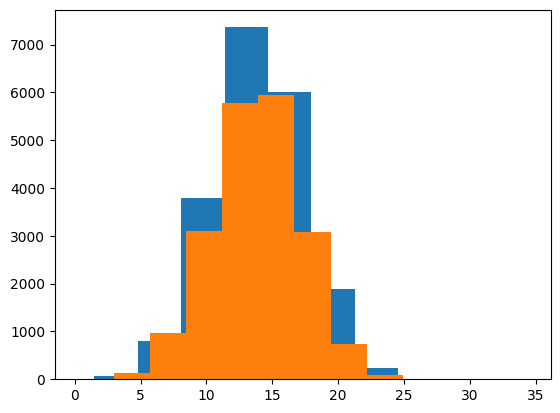

In [72]:
plt.hist(M[w, 0])
plt.hist(M[~w, 0])

# Compute margin datamodels (Vitaly's version)

In [64]:
masks.shape

(40000, 50000)

In [65]:
margins.shape

torch.Size([40000, 60000])

In [69]:
scores = ch.zeros(50_000, 60_000).cuda()
masks = ch.from_numpy(masks).cuda()
margins = margins.cuda()

In [86]:
for tr_i in tqdm(range(50_000)):
    # for val_i in range(60_000):
    w = masks[:, tr_i] == 1
    # scores[tr_i, val_i] = margins[w, val_i].mean() - margins[~w, val_i].mean()
    scores[tr_i] = margins[w].mean(dim=0) - margins[~w].mean(dim=0)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [73]:
DMS_PATH

PosixPath('/mnt/xfs/projects/untrak/MATCHING/DATAMODELS/CIFAR10')

In [87]:
ch.save(scores, DMS_PATH / "margin_scores_vitaly.pt")

# Visual sanity checks

In [27]:
scores = ch.load(DMS_PATH / "margin_scores_vitaly.pt")

In [14]:
from matplotlib import pyplot as plt
def get_img(t):
    t = t.permute(1, 2, 0).cpu().numpy()
    t -= t.min()
    t /= t.max()
    return t

In [15]:
idx = 15
top_infls = scores[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
bottom_infls = scores[:, idx].argsort()[:5].cpu().numpy().tolist()
plt.figure(figsize=(2, 2))
plt.imshow(get_img(train_ds[idx][0]))
plt.title(f"Label: {train_ds[idx][1]}, Influence: {idx}")
plt.axis('off')
plt.show()
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, infl in enumerate(top_infls):
    axs[i].imshow(get_img(train_ds[infl][0]))
    axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
    axs[i].axis('off')
plt.show()
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, infl in enumerate(bottom_infls):
    axs[i].imshow(get_img(train_ds[infl][0]))
    axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
    axs[i].axis('off')
plt.show()

NameError: name 'scores' is not defined

# Logit 5 vitaly

In [14]:
logits = ch.load(DMS_PATH / "all_logits.pt")

In [13]:
scores_logit_5 = ch.zeros(50_000, 60_000).cuda()
masks = ch.from_numpy(masks).cuda()
logits_5 = logits[:, :, 5].cuda()

In [16]:
masks.shape

(40000, 50000)

In [84]:
logits_5.shape

torch.Size([40000, 60000])

In [86]:
w.shape

torch.Size([40000])

In [14]:
for tr_i in tqdm(range(50_000)):
    w = masks[:, tr_i] == 1
    # scores[tr_i, val_i] = margins[w, val_i].mean() - margins[~w, val_i].mean()
    scores_logit_5[tr_i] = logits_5[w].mean(dim=0) - logits_5[~w].mean(dim=0)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [15]:
ch.save(scores_logit_5, DMS_PATH / "logit5_scores_vitaly.pt")

In [17]:
from matplotlib import pyplot as plt

In [18]:
np.arange(50_000)[np.array(train_labels) == 5]

array([   27,    40,    51, ..., 49964, 49980, 49988])

In [79]:
scores_logit_5.shape

torch.Size([50000, 60000])

In [19]:
from numpy.lib.format import open_memmap as om
DMS_SCORES_PATH = "/mnt/xfs/projects/untrak/regression_v2/all_logit_vitaly_infls_denoised.npy"
_dms_matrix = om(DMS_SCORES_PATH, mode="r")

In [20]:
S = _dms_matrix[:, :, 5]

In [26]:
offenders = []
for idx in np.arange(50_000)[np.array(train_labels) == 5][:5000]:
    # top_infls = scores_logit_5[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
    # bottom_infls = scores_logit_5[:, idx].argsort()[:5].cpu().numpy().tolist()
    # top_infls = S[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
    # bottom_infls = S[:, idx].argsort()[:5].cpu().numpy().tolist()
    top_infls = S[:, idx].argsort()[-5:].tolist()[::-1]
    bottom_infls = S[:, idx].argsort()[:5].tolist()
    if idx in bottom_infls:
        offenders.append(idx)
        # plt.figure(figsize=(2, 2))
        # plt.imshow(get_img(train_ds[idx][0]))
        # plt.title(f"Label: {train_ds[idx][1]}, Influence: {idx}")
        # plt.axis('off')
        # plt.show()
        # fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        # for i, infl in enumerate(top_infls):
        #     axs[i].imshow(get_img(train_ds[infl][0]))
        #     axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        #     axs[i].axis('off')
        # plt.show()
        # fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        # for i, infl in enumerate(bottom_infls):
        #     axs[i].imshow(get_img(train_ds[infl][0]))
        #     axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        #     axs[i].axis('off')
        # plt.show()

In [34]:
np.save("/mnt/xfs/projects/untrak/MATCHING/OFFENDERS.npy", np.array(offenders))

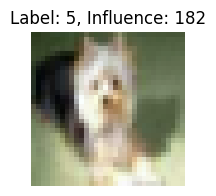

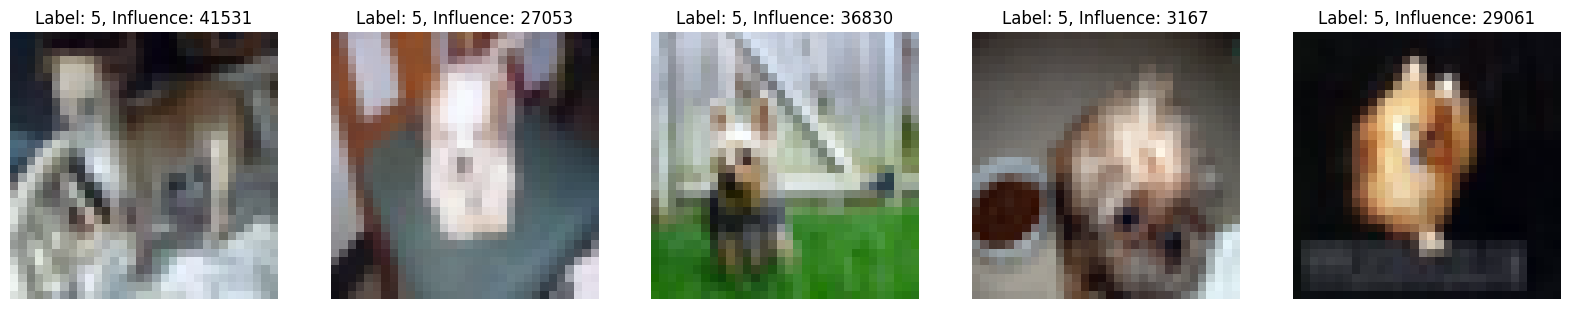

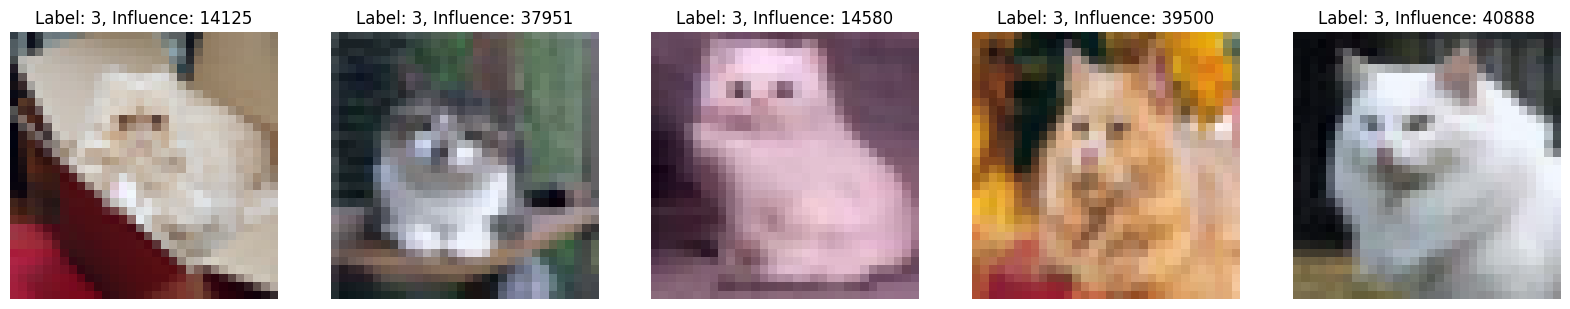

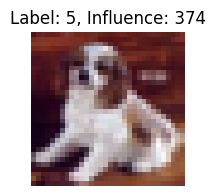

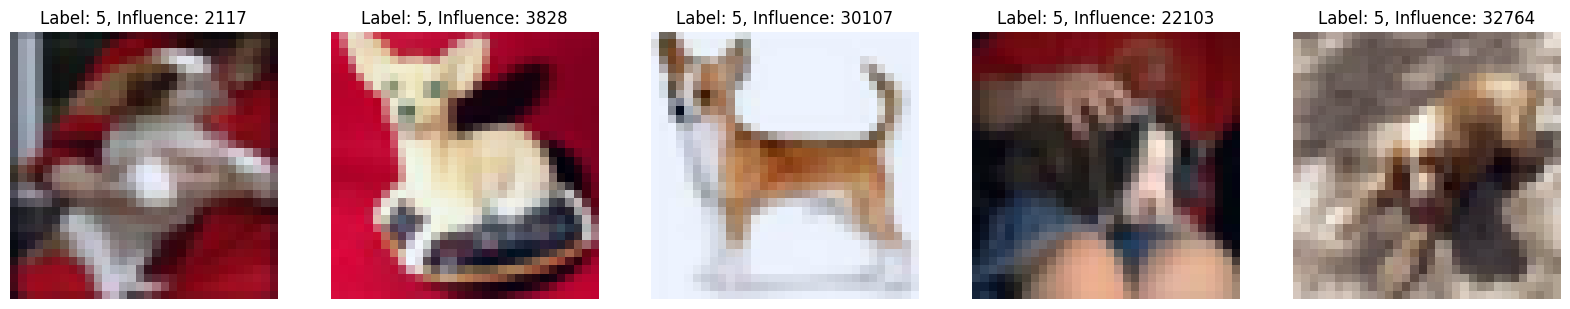

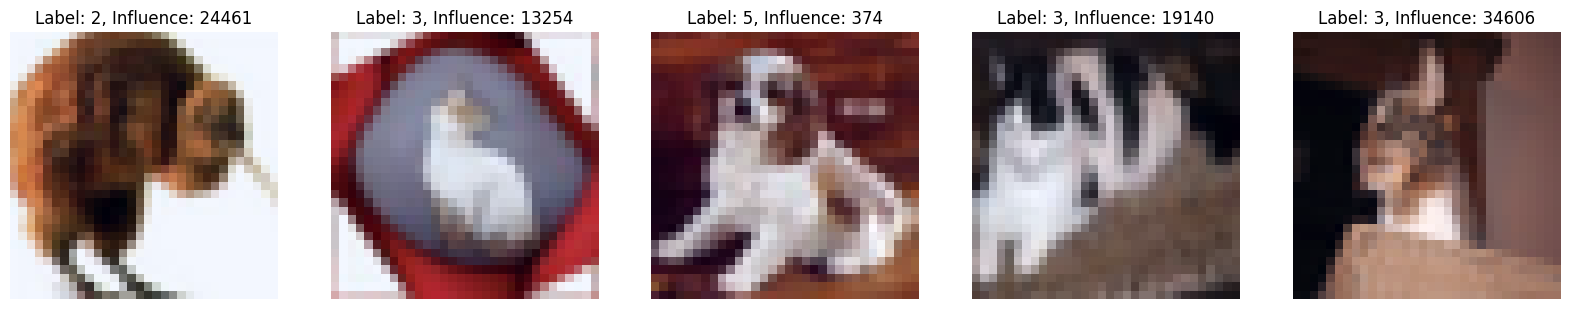

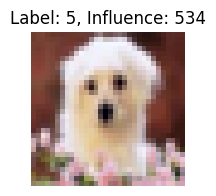

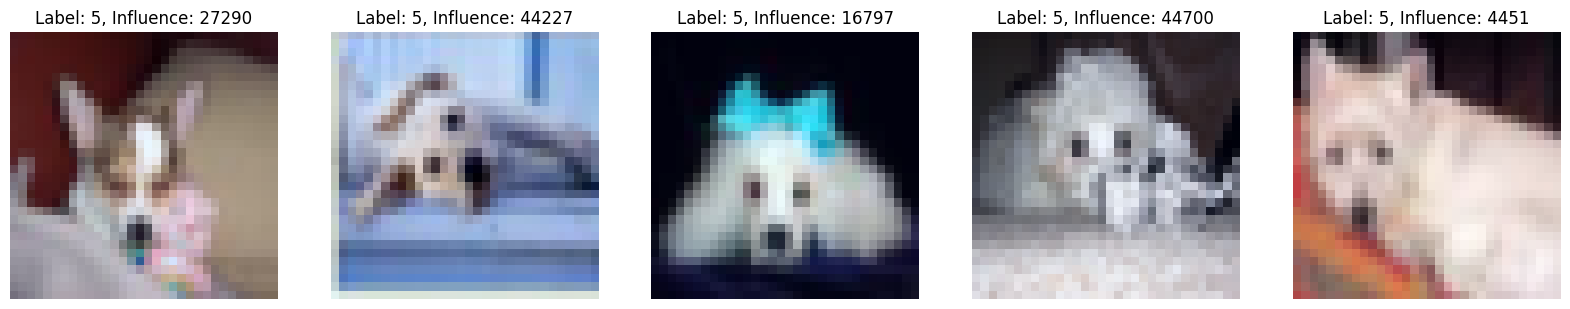

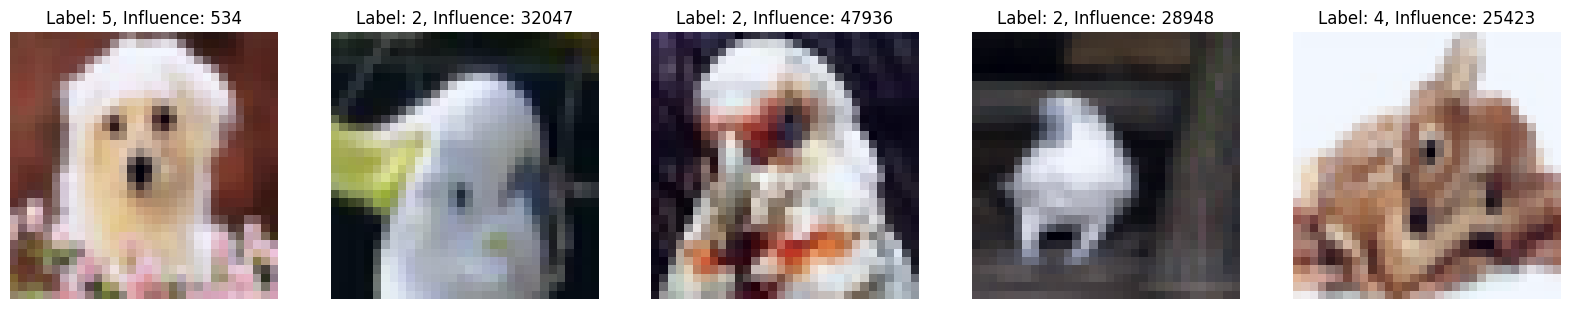

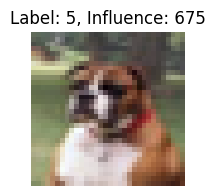

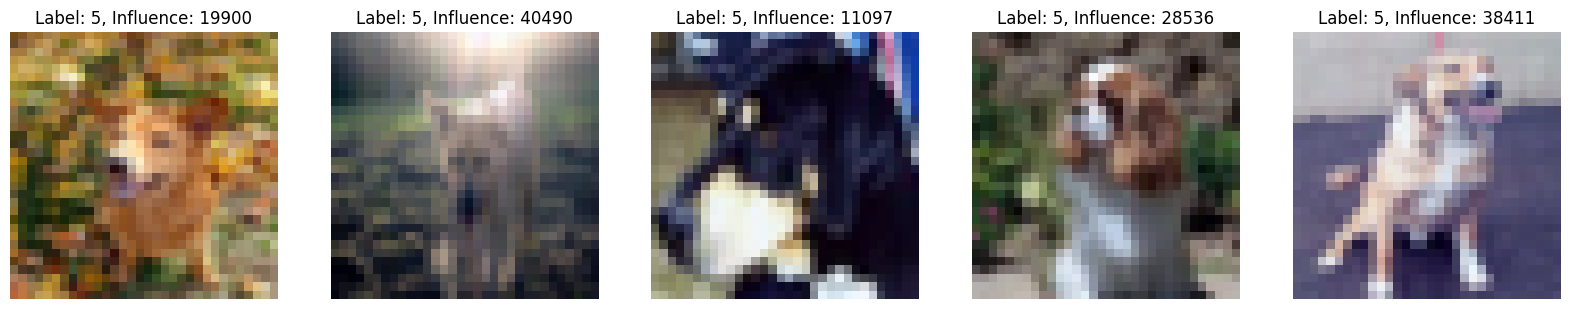

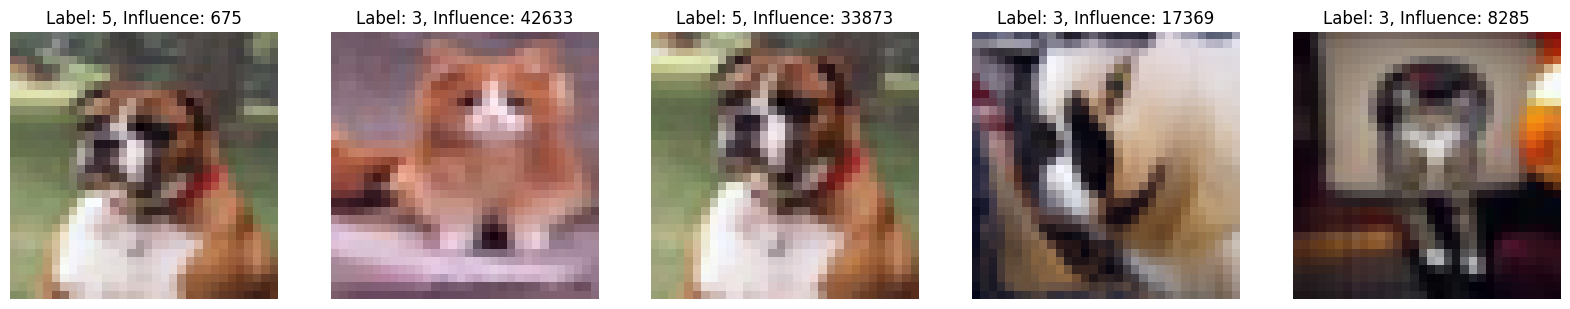

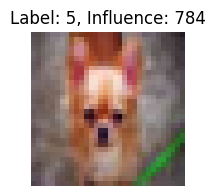

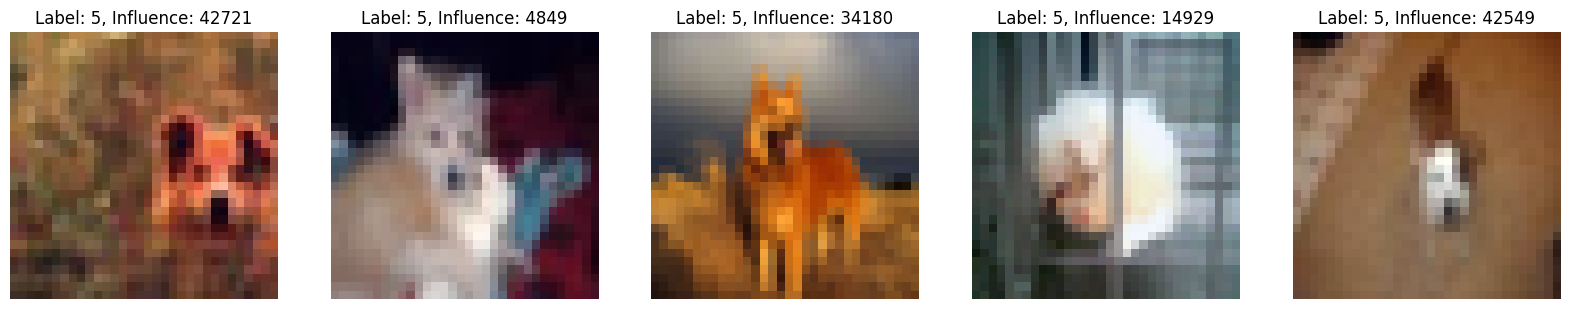

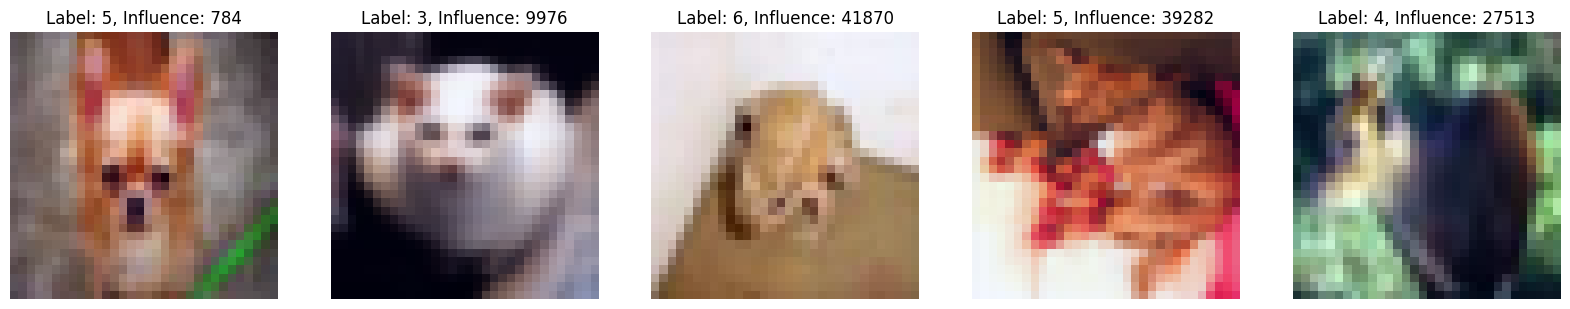

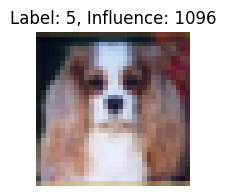

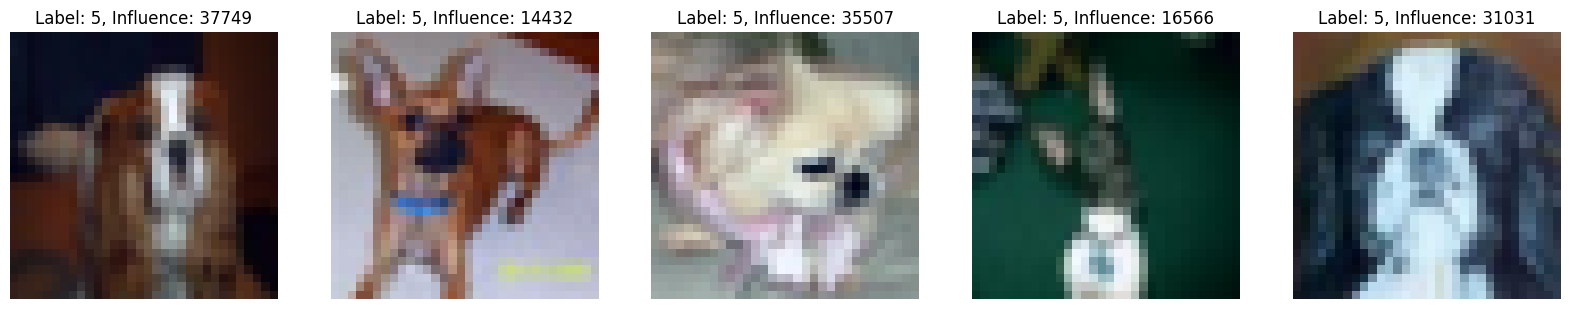

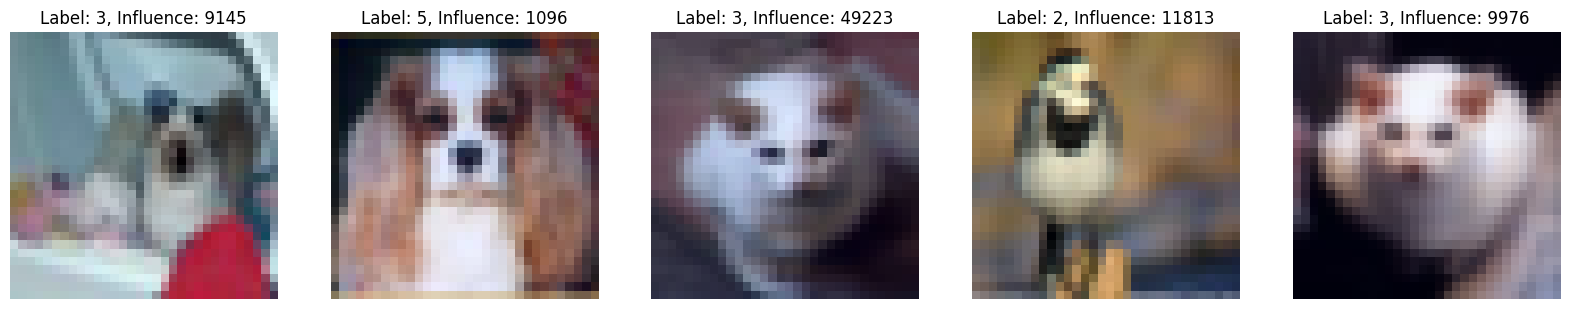

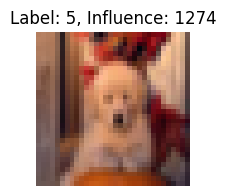

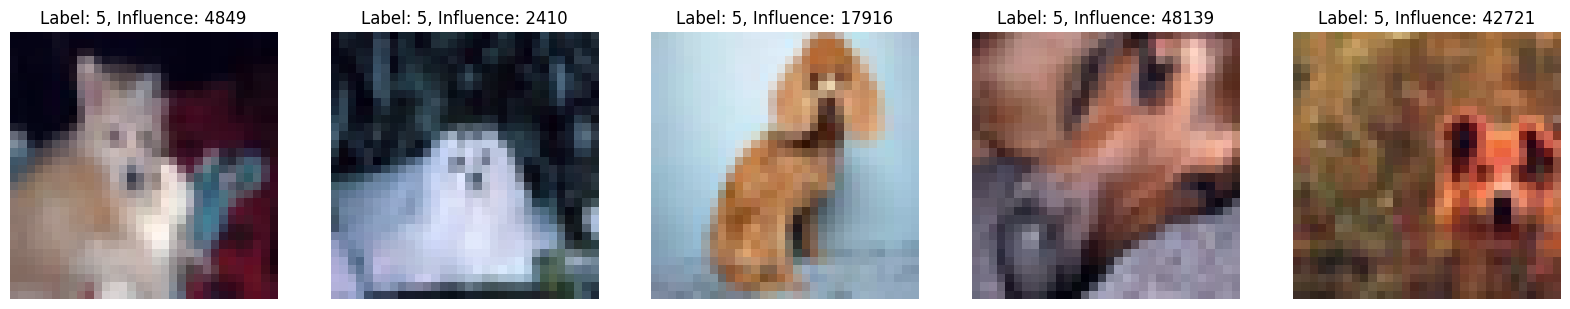

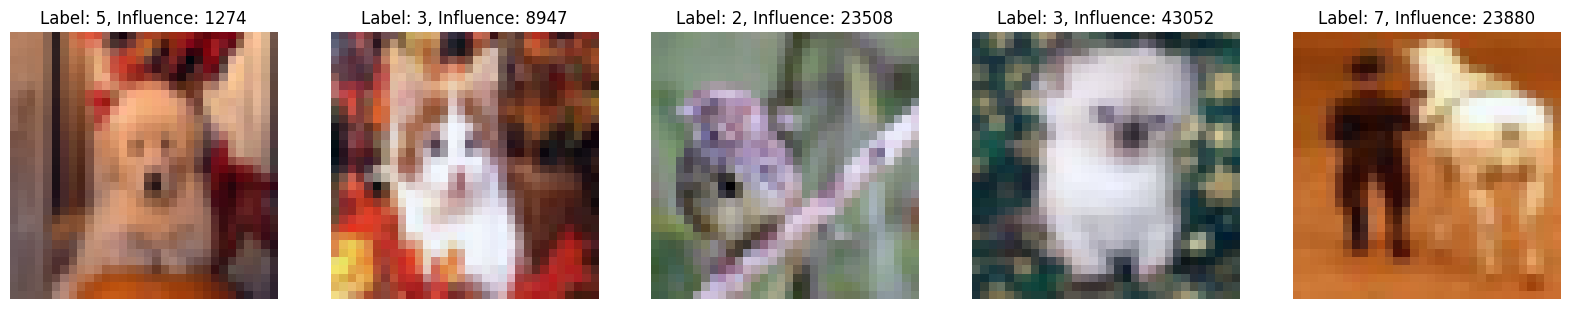

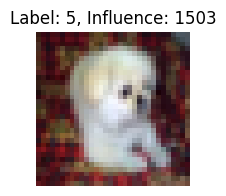

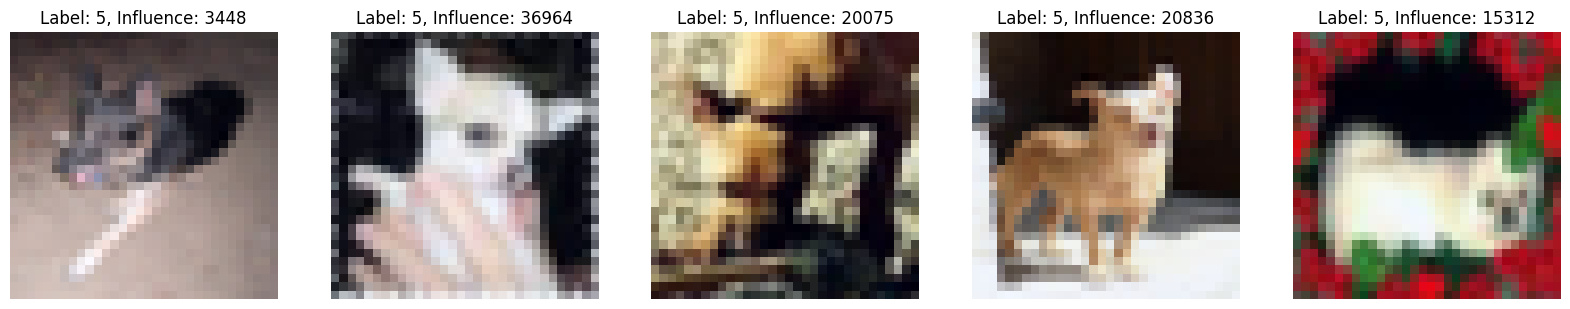

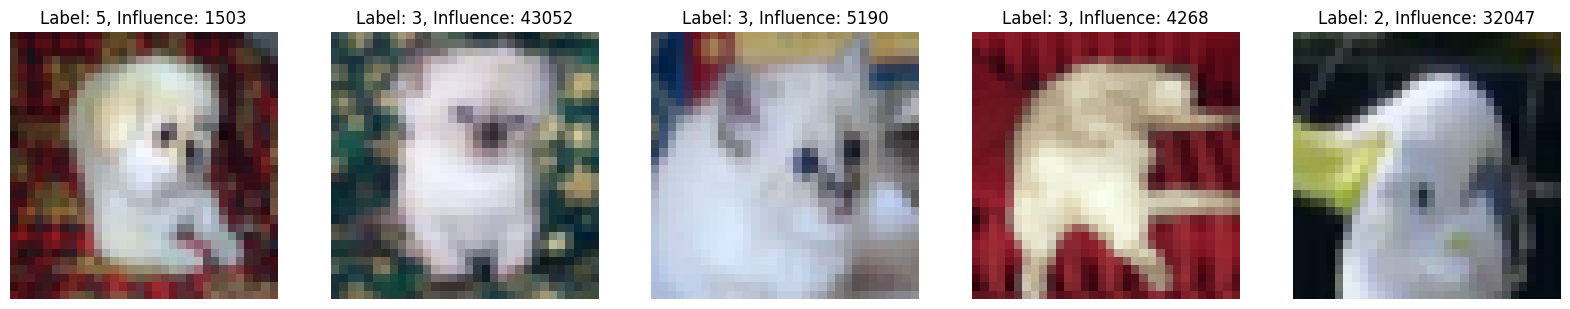

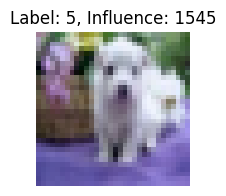

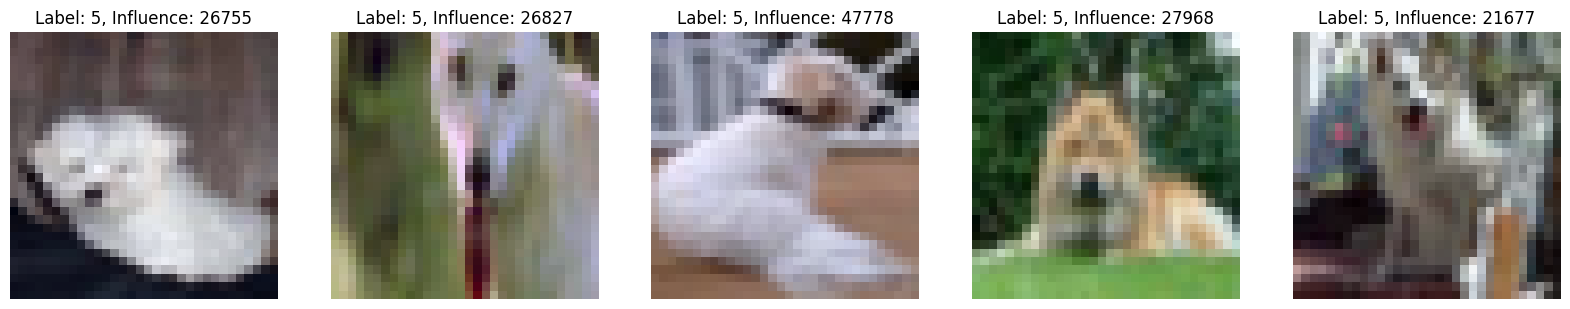

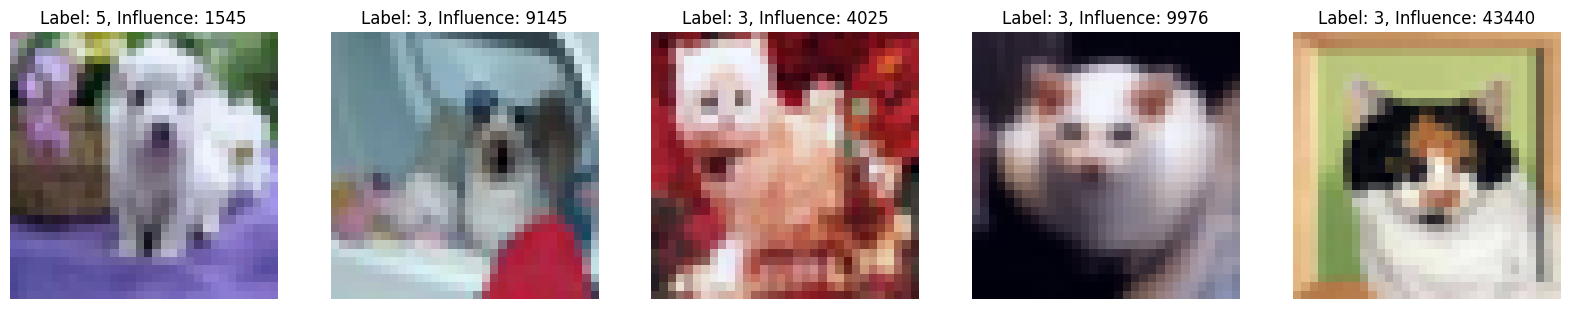

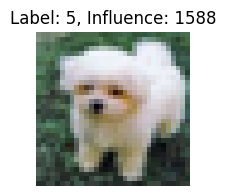

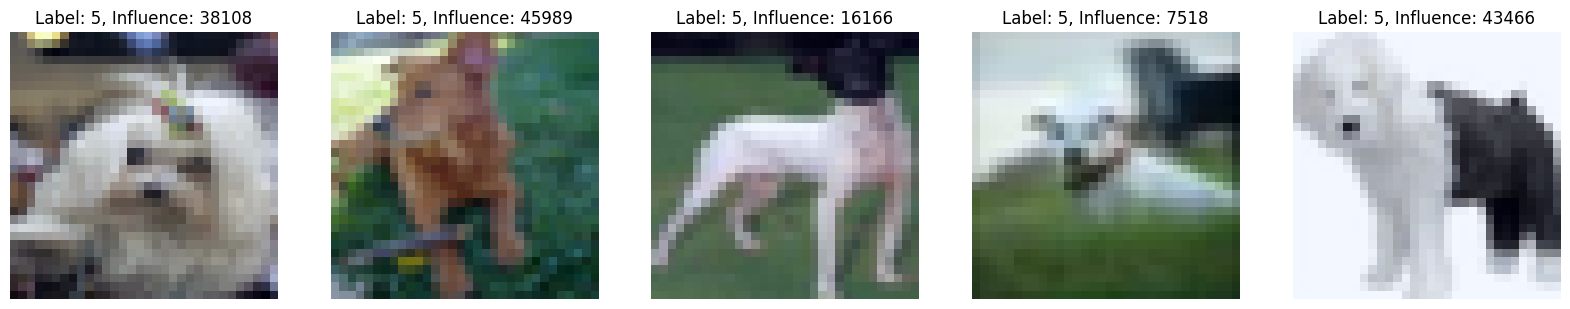

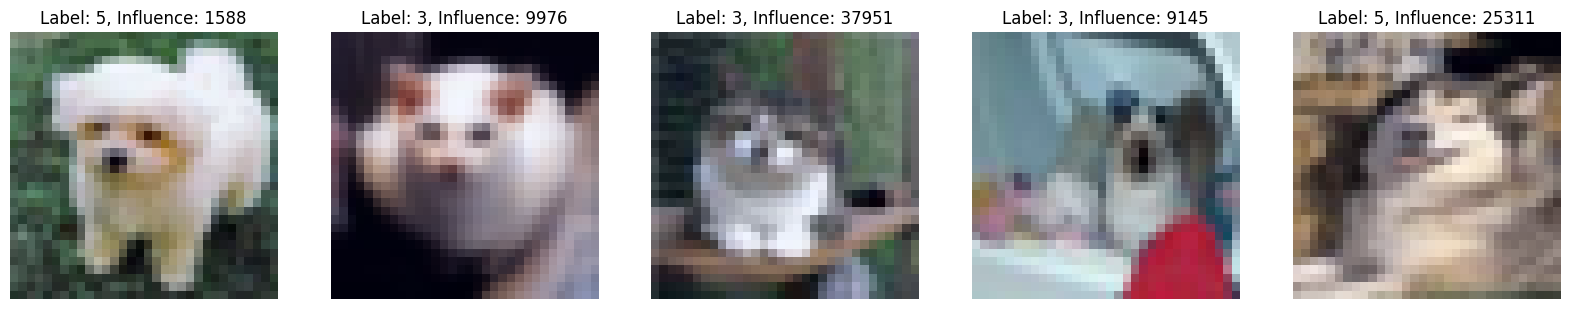

In [32]:
for idx in offenders[:10]:
    top_infls = scores[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
    bottom_infls = scores[:, idx].argsort()[:5].cpu().numpy().tolist()
    # top_infls = S[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
    # bottom_infls = S[:, idx].argsort()[:5].cpu().numpy().tolist()
    # top_infls = S[:, idx].argsort()[-5:].tolist()[::-1]
    # bottom_infls = S[:, idx].argsort()[:5].tolist()
    plt.figure(figsize=(2, 2))
    plt.imshow(get_img(train_ds[idx][0]))
    plt.title(f"Label: {train_ds[idx][1]}, Influence: {idx}")
    plt.axis('off')
    plt.show()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, infl in enumerate(top_infls):
        axs[i].imshow(get_img(train_ds[infl][0]))
        axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        axs[i].axis('off')
    plt.show()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, infl in enumerate(bottom_infls):
        axs[i].imshow(get_img(train_ds[infl][0]))
        axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        axs[i].axis('off')
    plt.show()

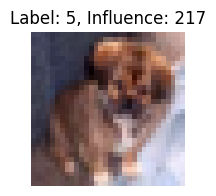

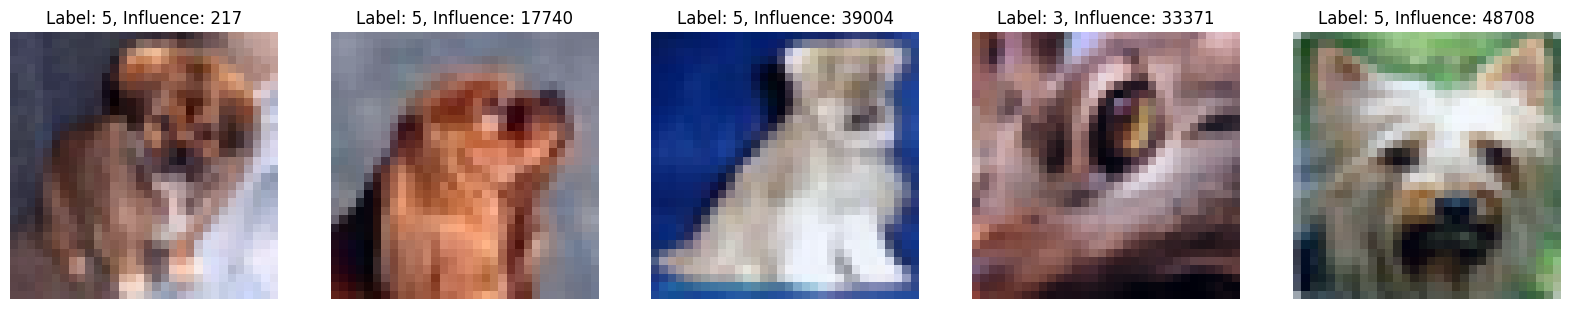

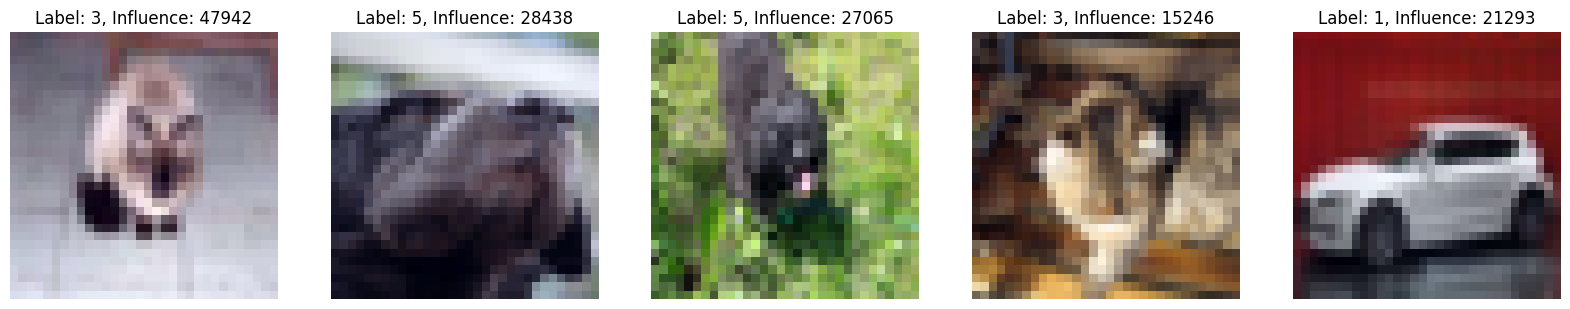

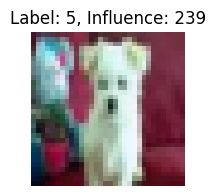

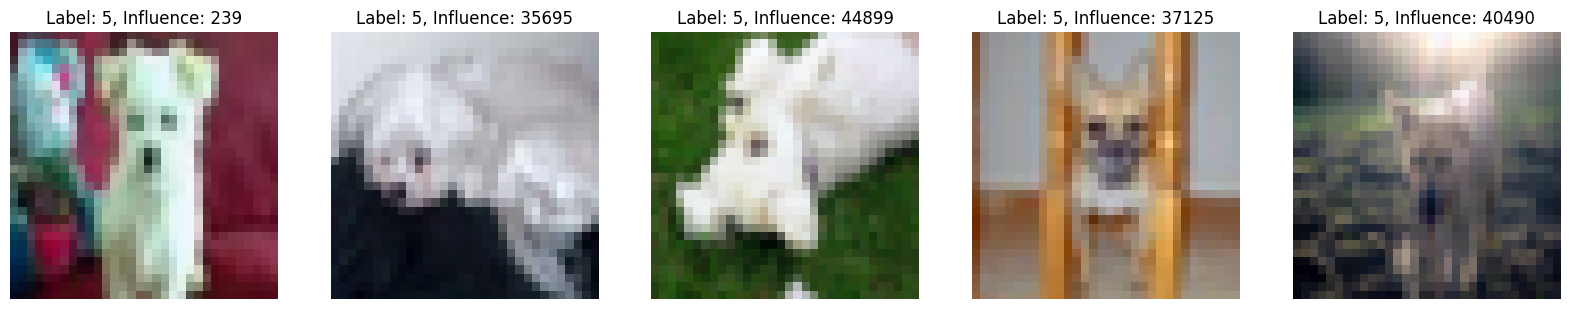

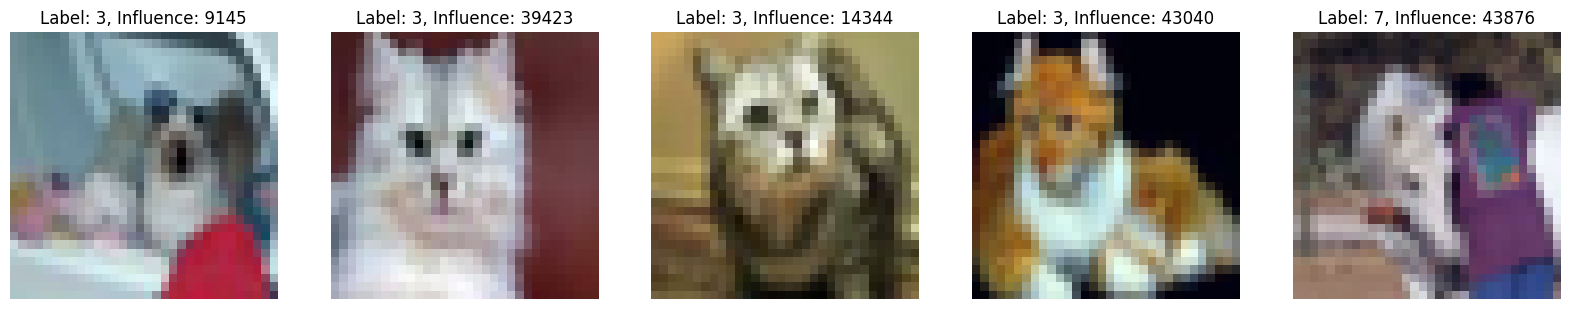

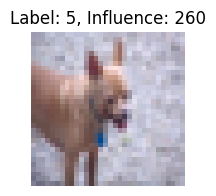

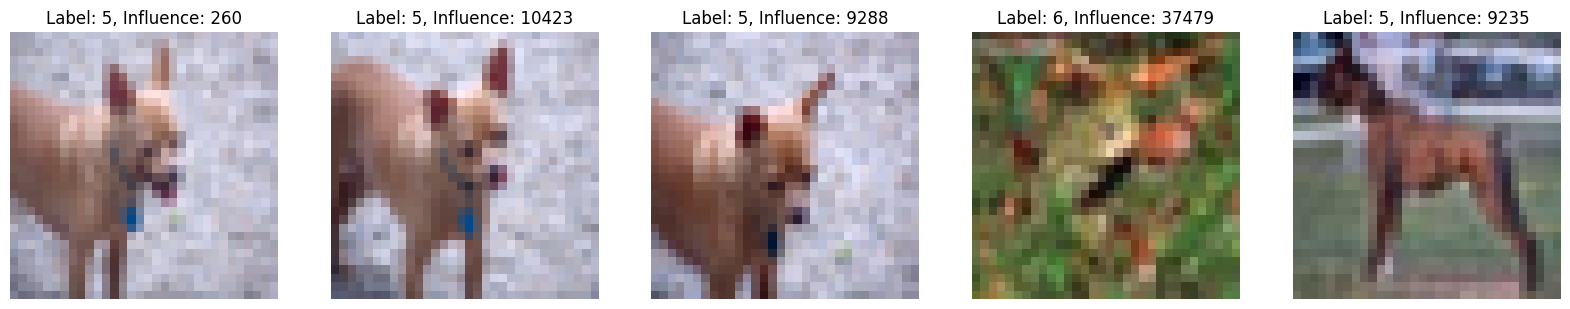

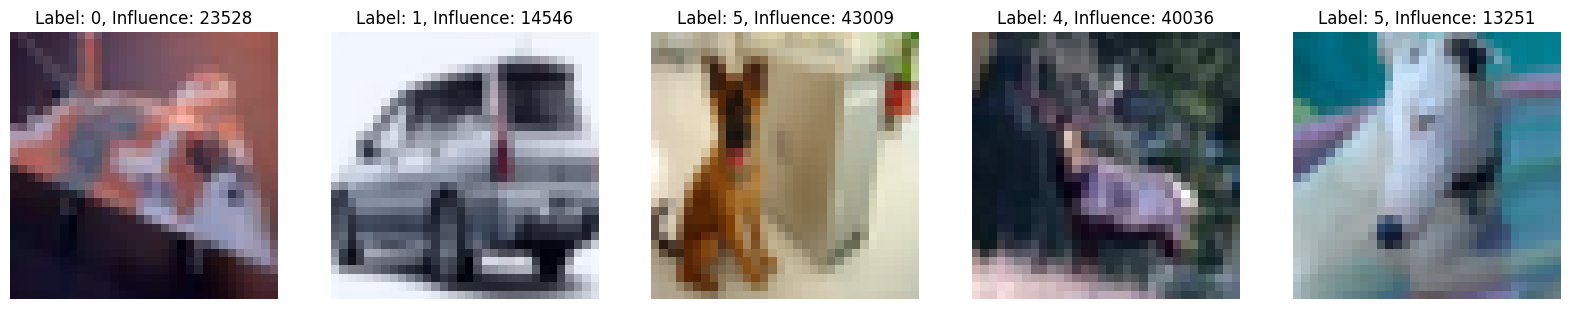

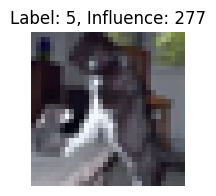

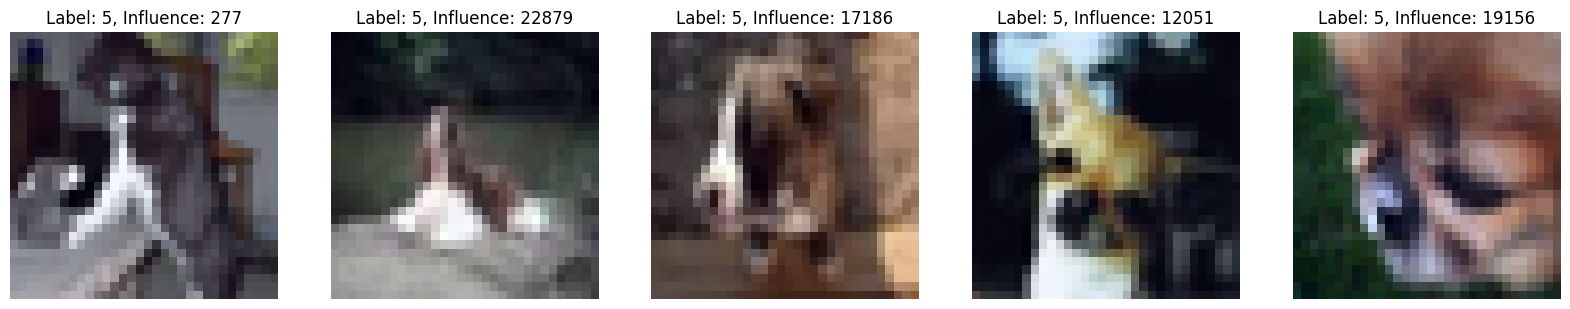

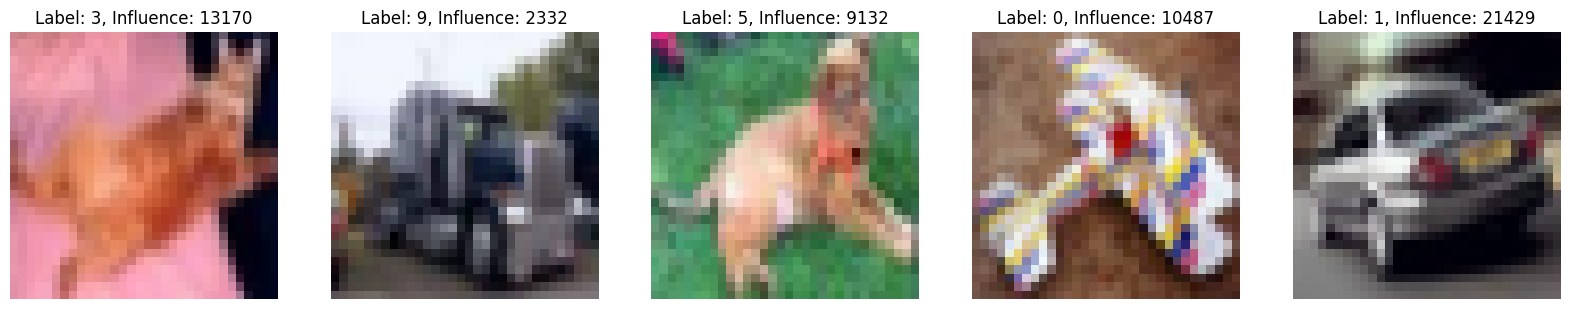

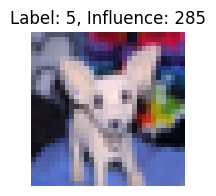

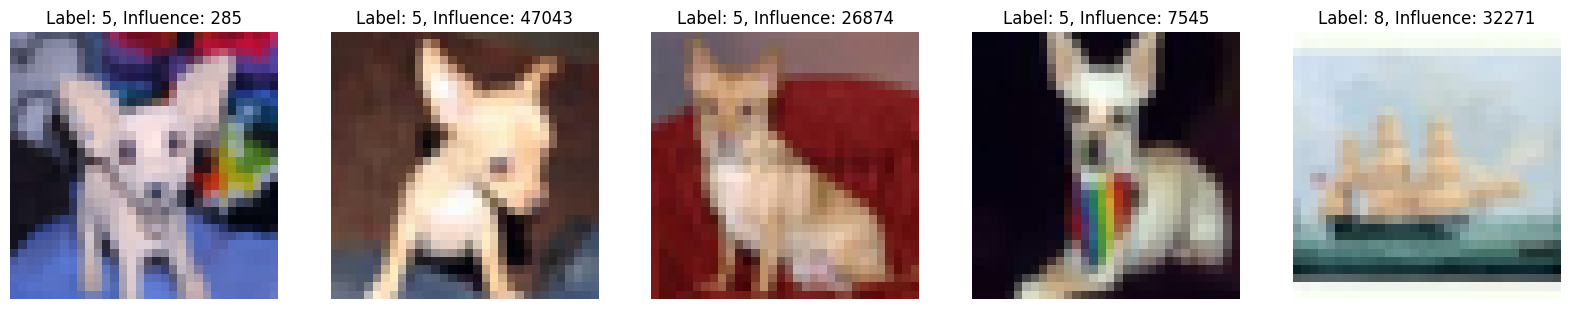

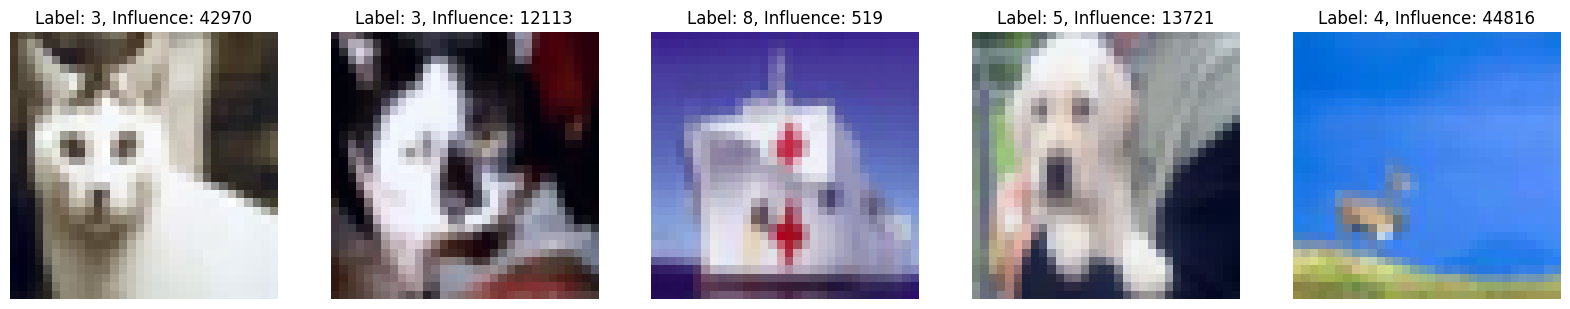

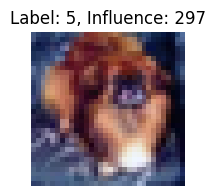

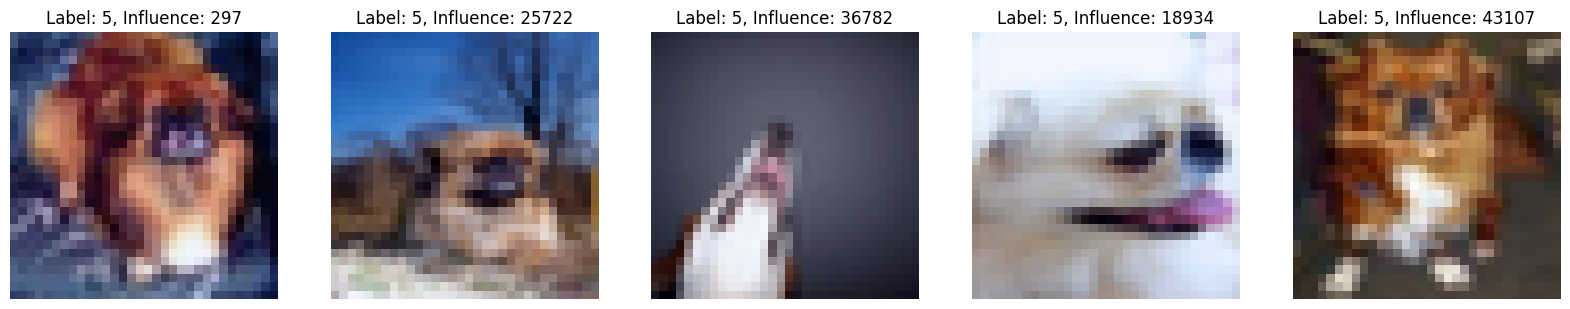

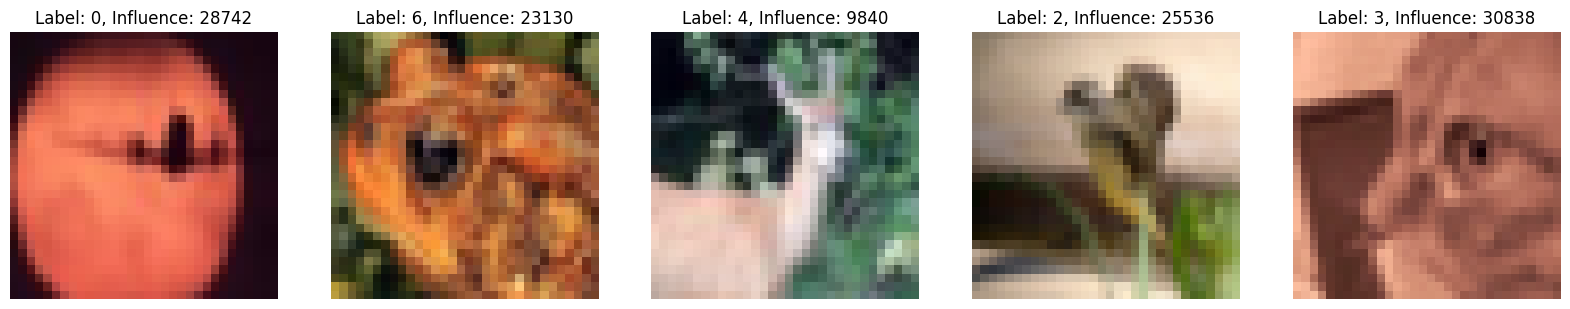

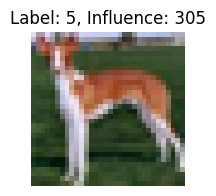

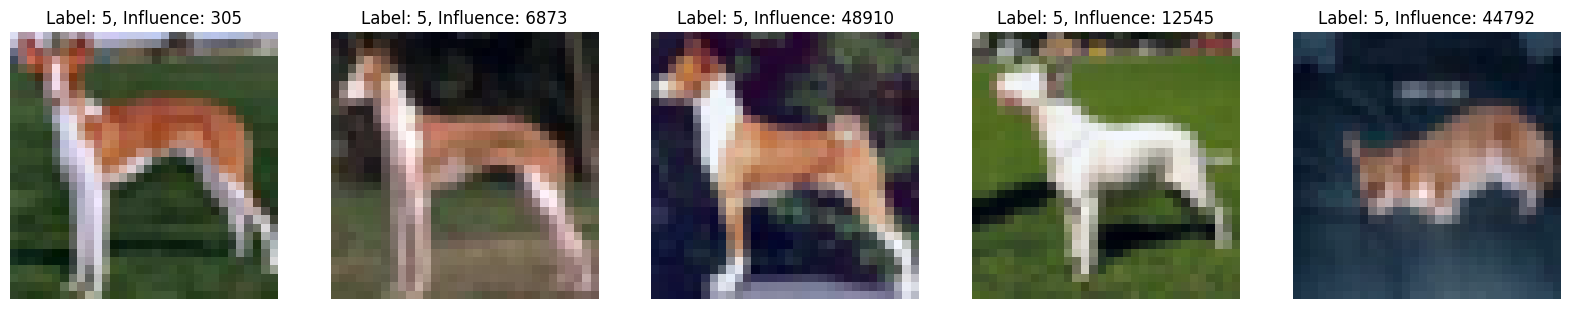

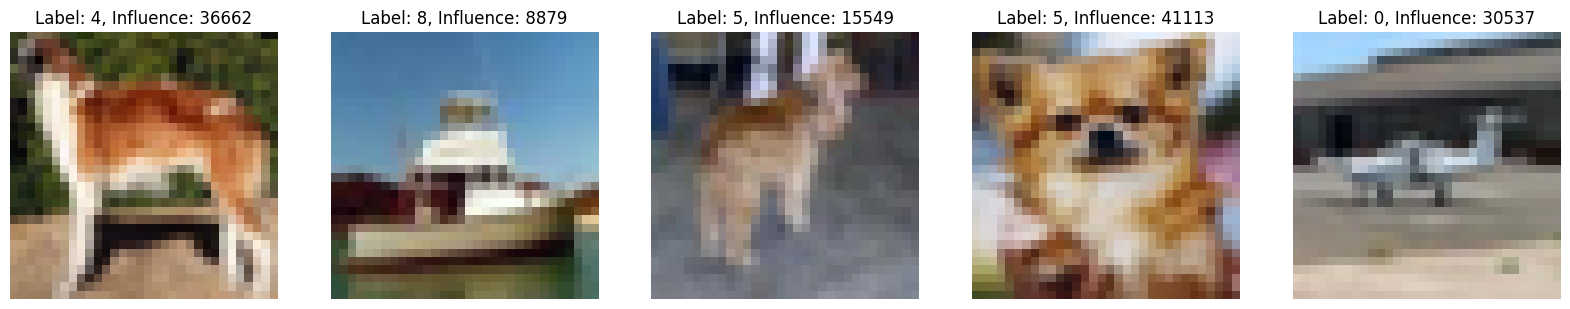

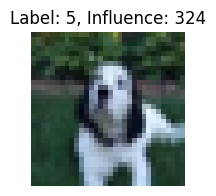

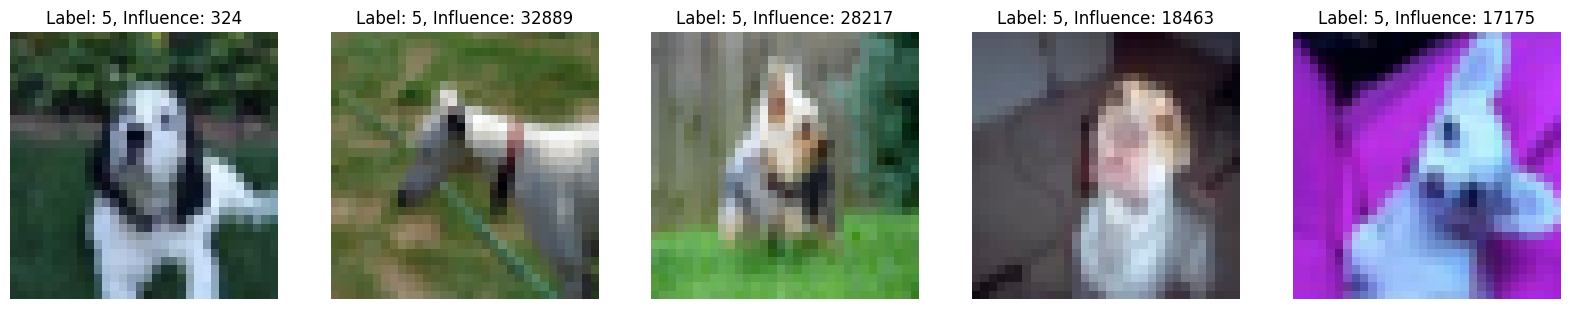

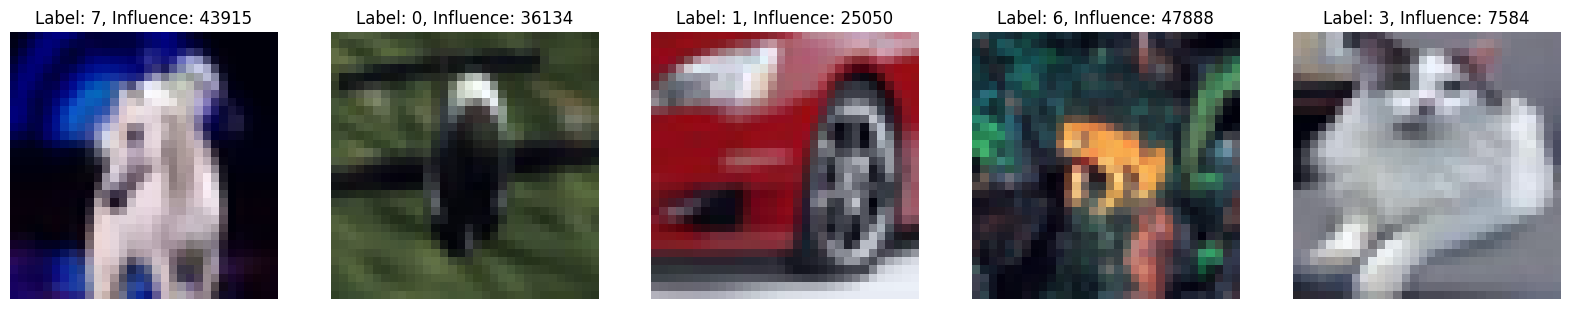

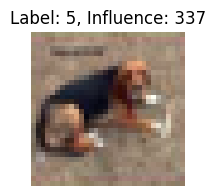

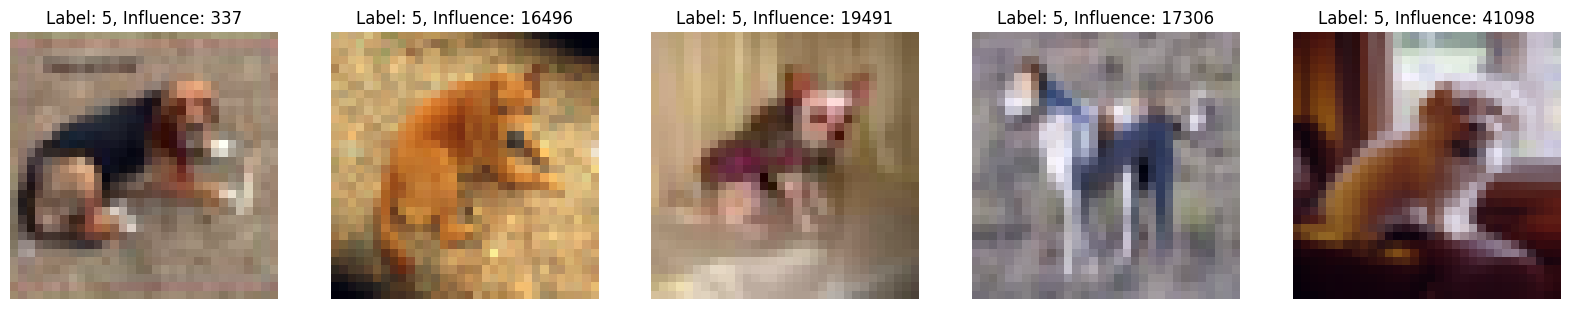

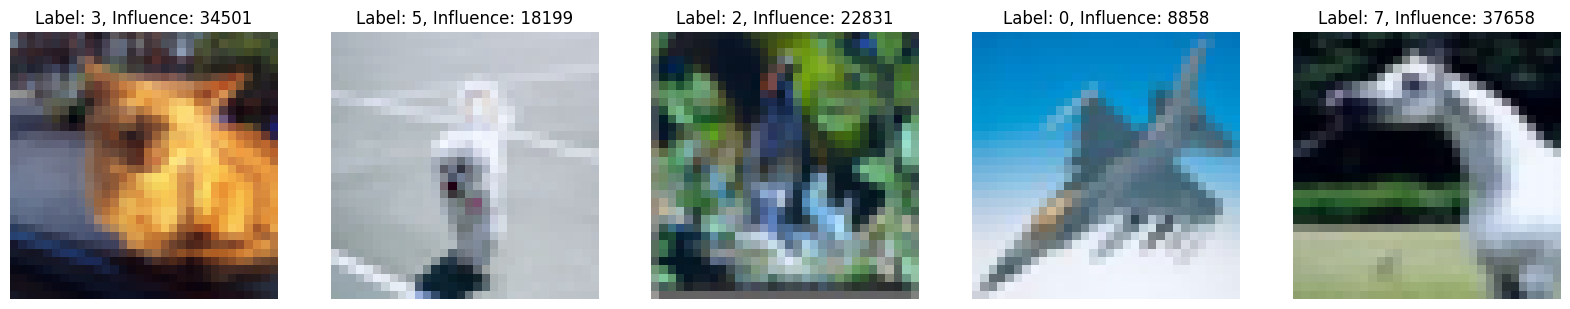

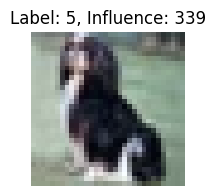

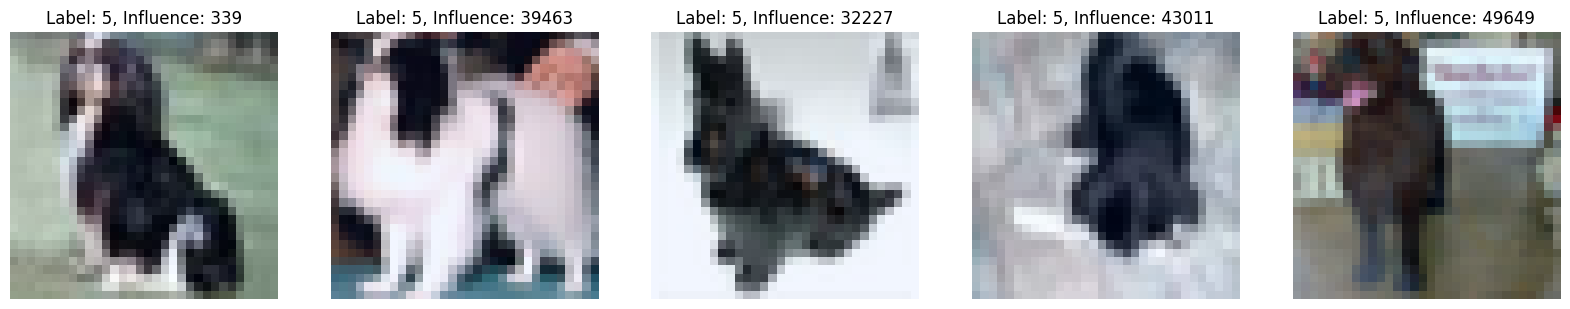

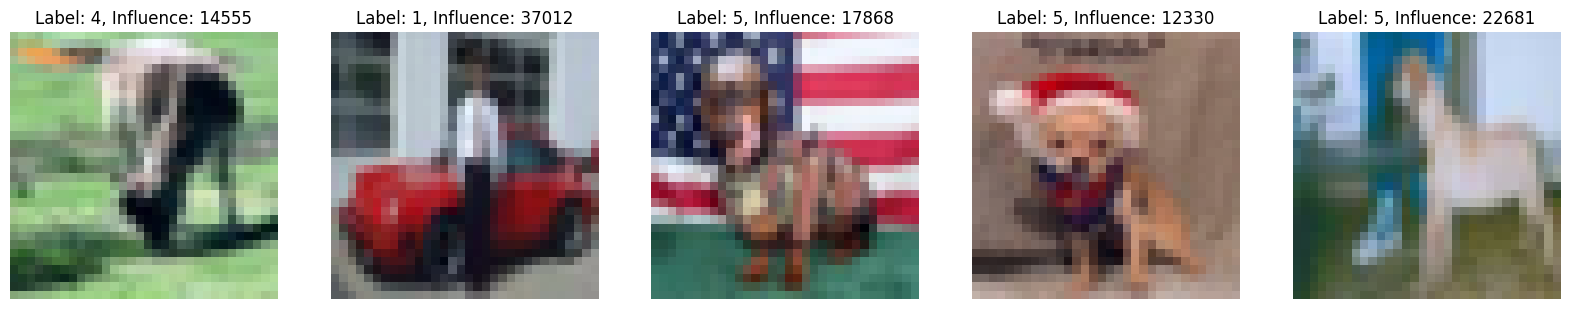

In [ ]:
for idx in np.arange(50_000)[np.array(train_labels) == 5][20:30]:
    # top_infls = scores_logit_5[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
    # bottom_infls = scores_logit_5[:, idx].argsort()[:5].cpu().numpy().tolist()
    # top_infls = S[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
    # bottom_infls = S[:, idx].argsort()[:5].cpu().numpy().tolist()
    top_infls = S[:, idx].argsort()[-5:].tolist()[::-1]
    bottom_infls = S[:, idx].argsort()[:5].tolist()
    plt.figure(figsize=(2, 2))
    plt.imshow(get_img(train_ds[idx][0]))
    plt.title(f"Label: {train_ds[idx][1]}, Influence: {idx}")
    plt.axis('off')
    plt.show()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, infl in enumerate(top_infls):
        axs[i].imshow(get_img(train_ds[infl][0]))
        axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        axs[i].axis('off')
    plt.show()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, infl in enumerate(bottom_infls):
        axs[i].imshow(get_img(train_ds[infl][0]))
        axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        axs[i].axis('off')
    plt.show()

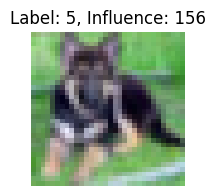

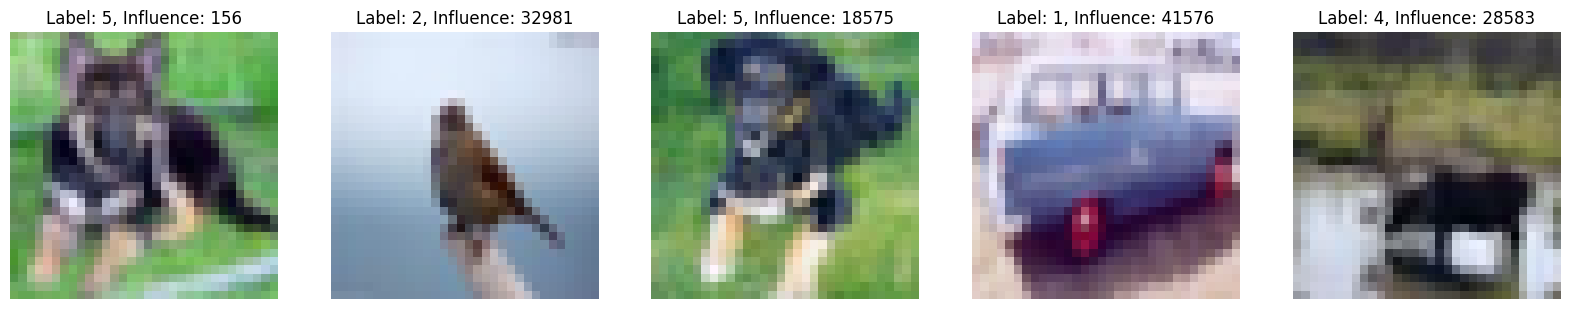

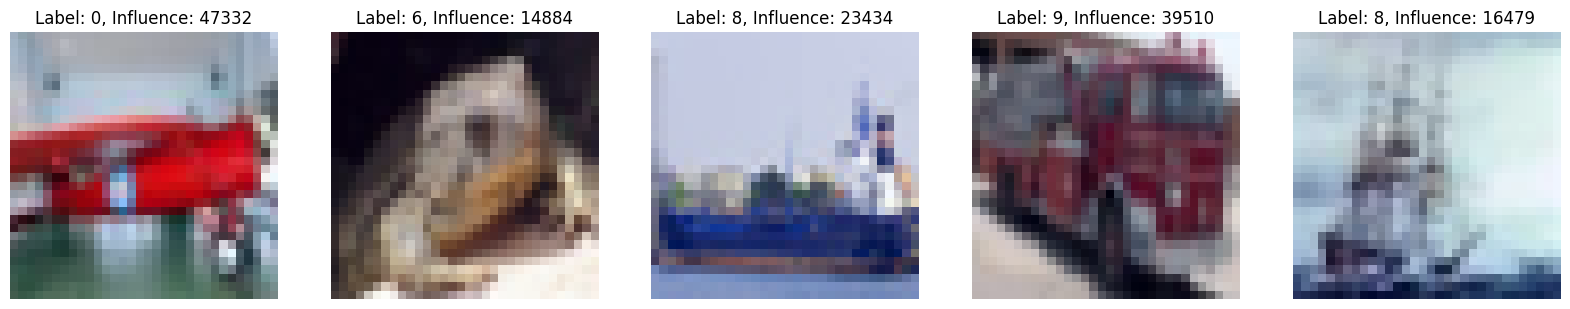

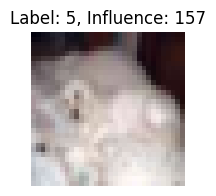

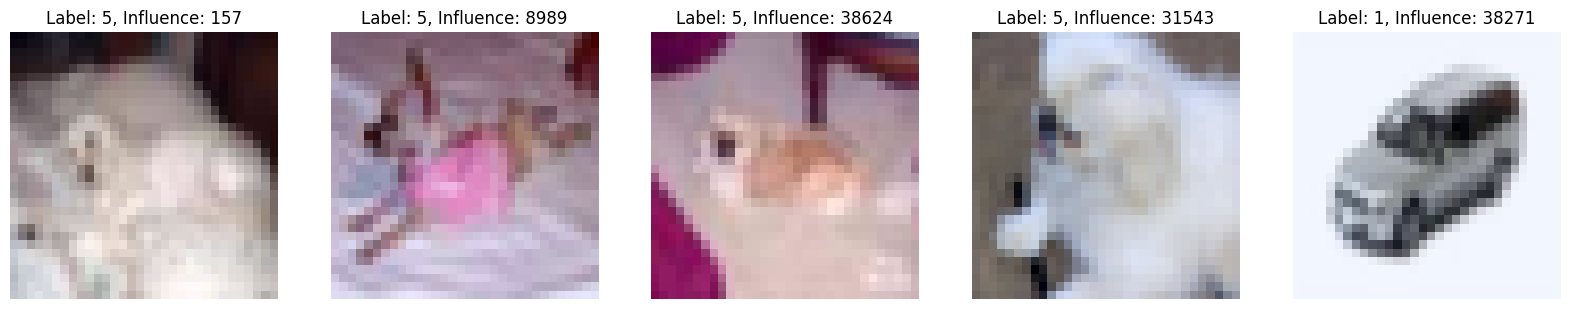

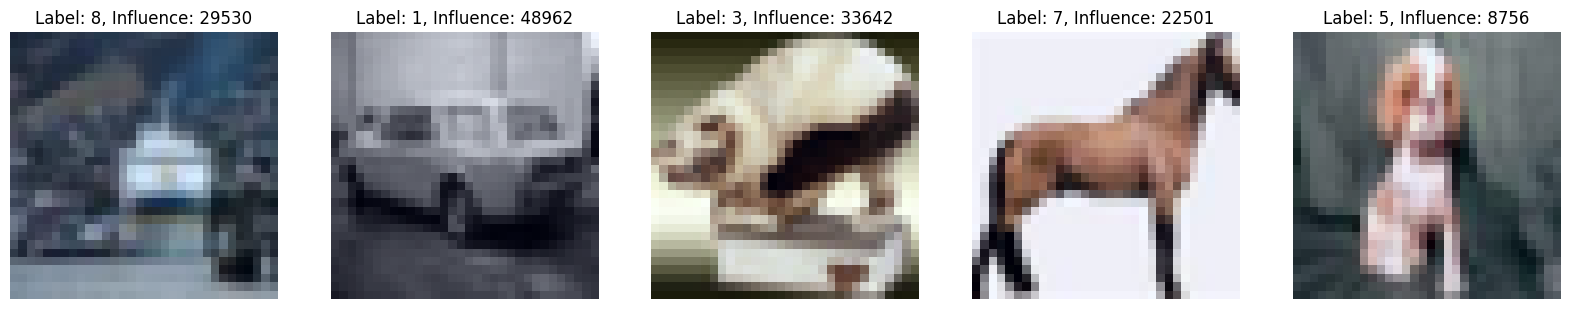

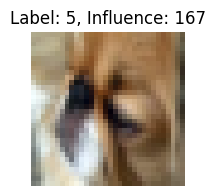

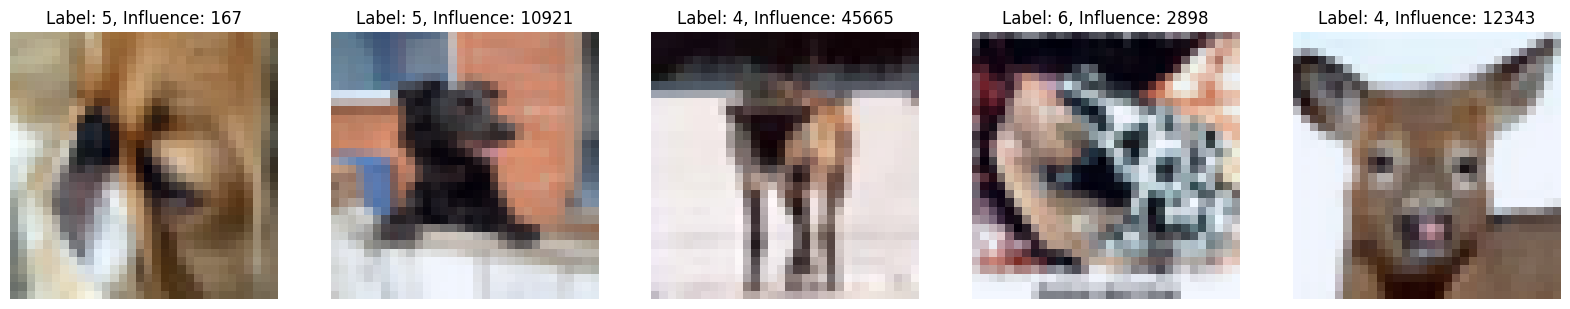

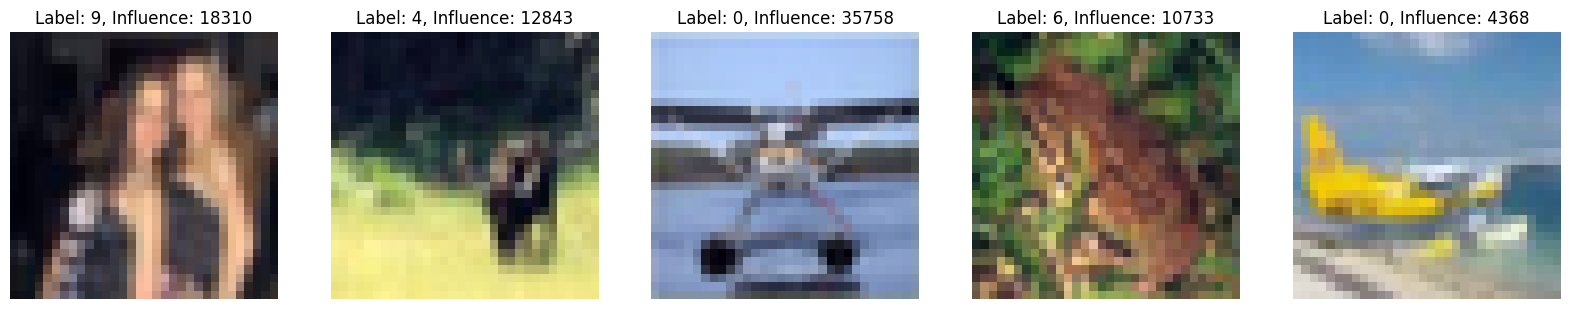

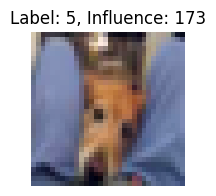

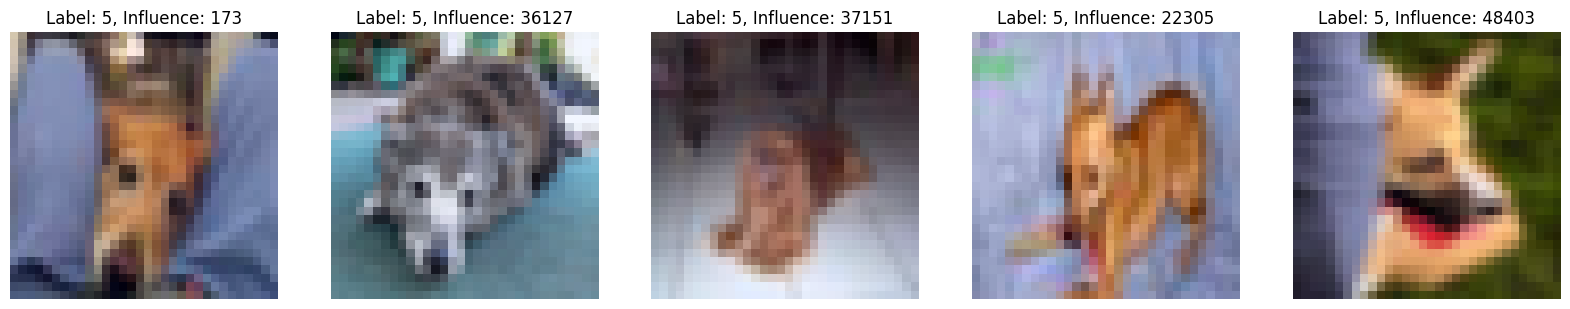

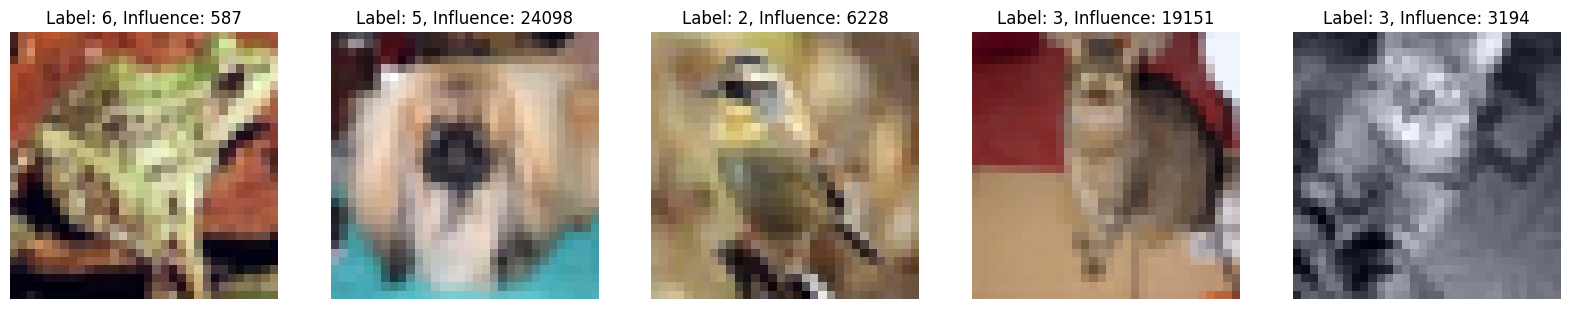

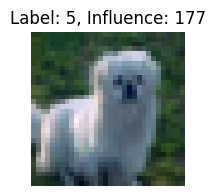

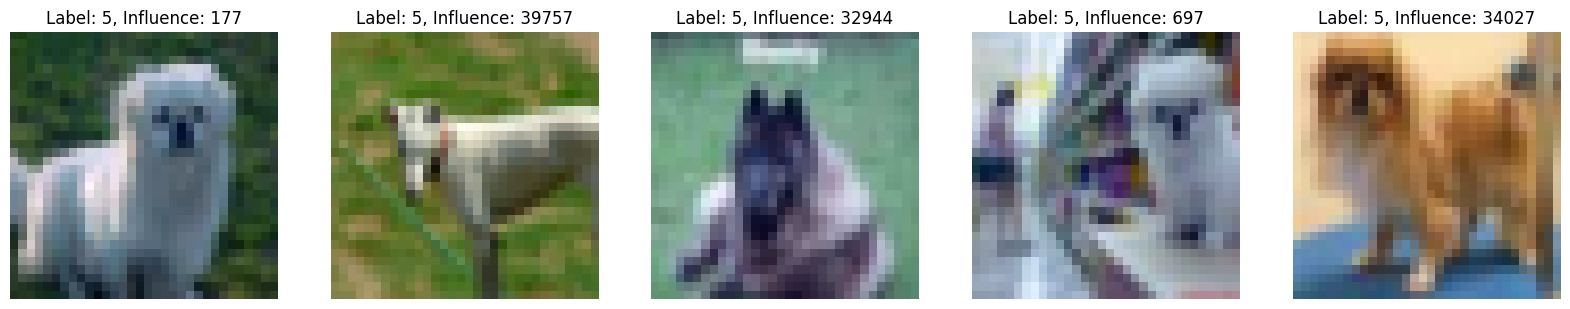

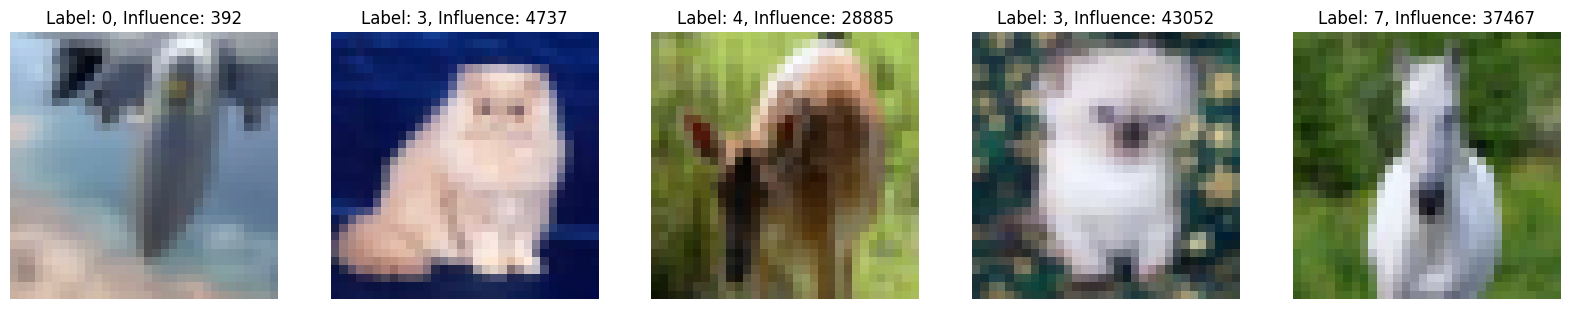

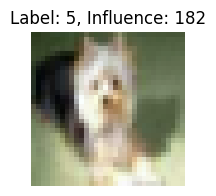

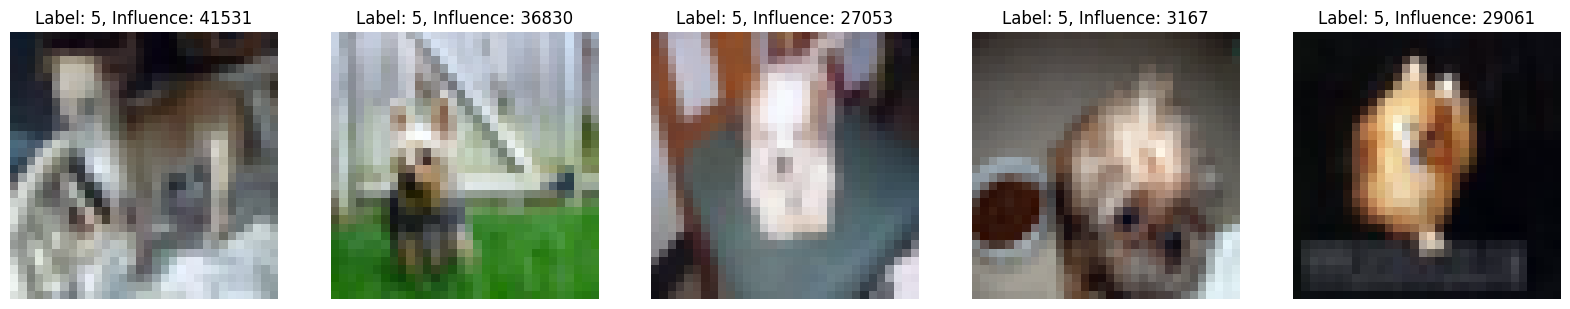

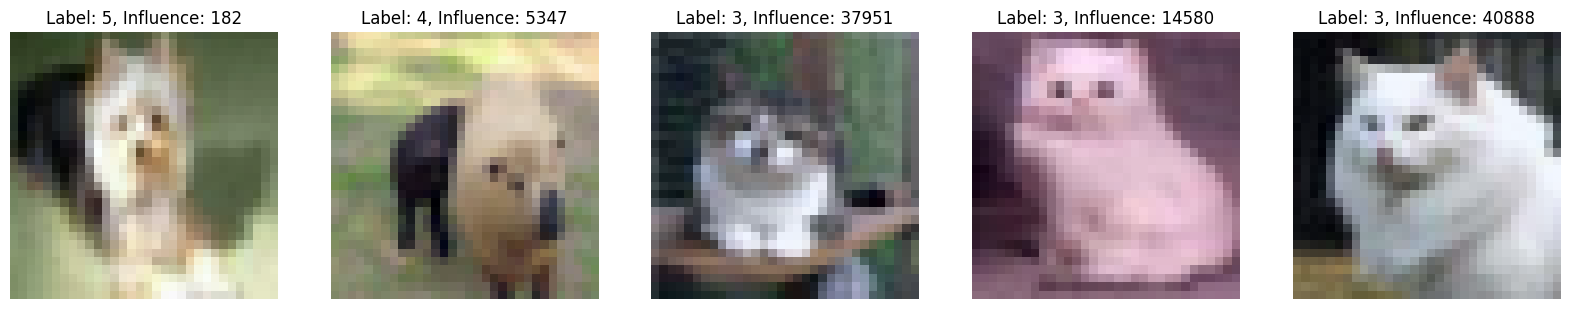

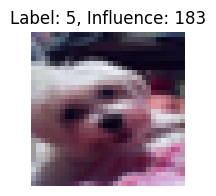

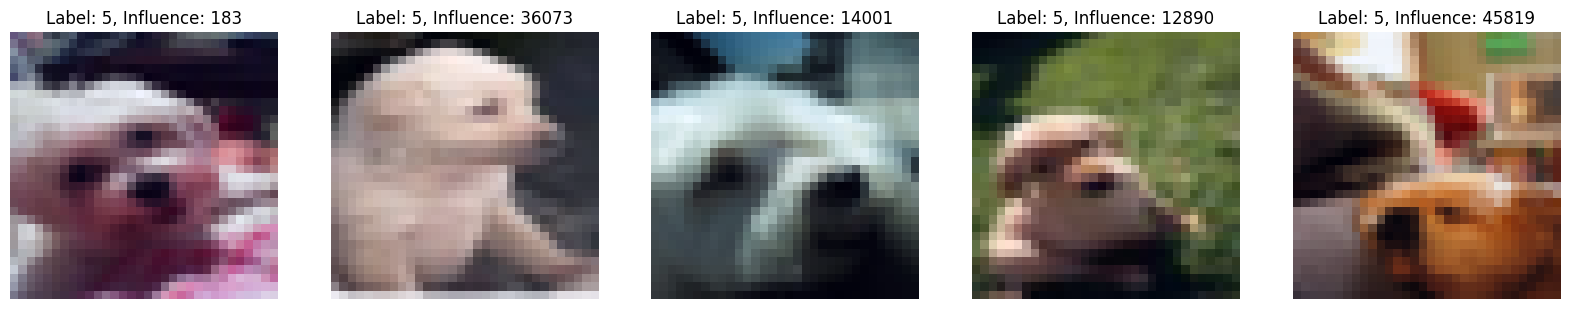

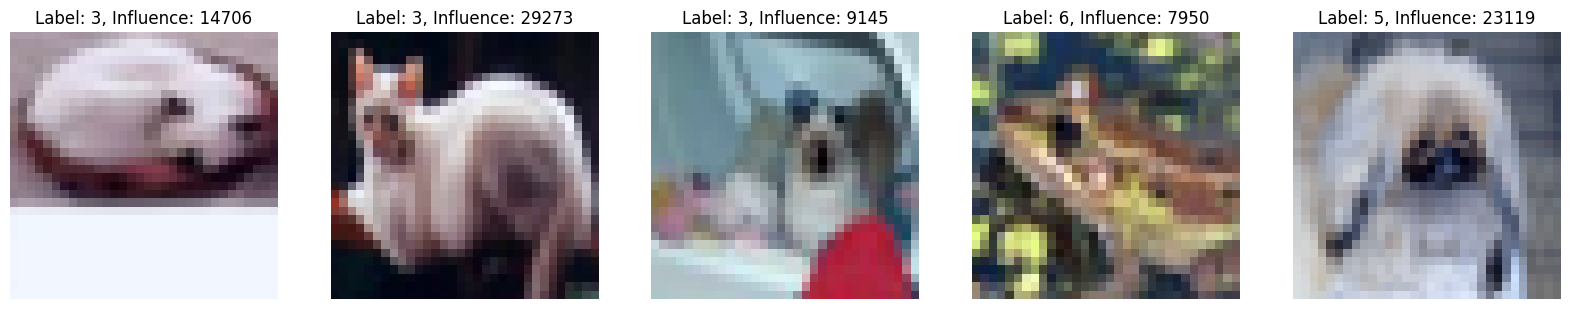

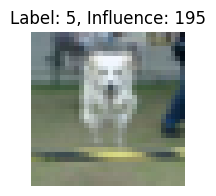

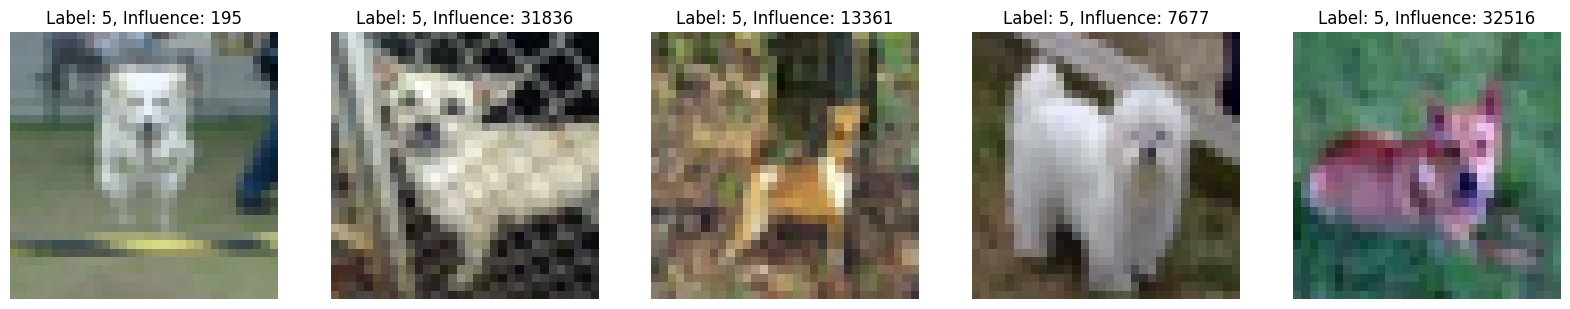

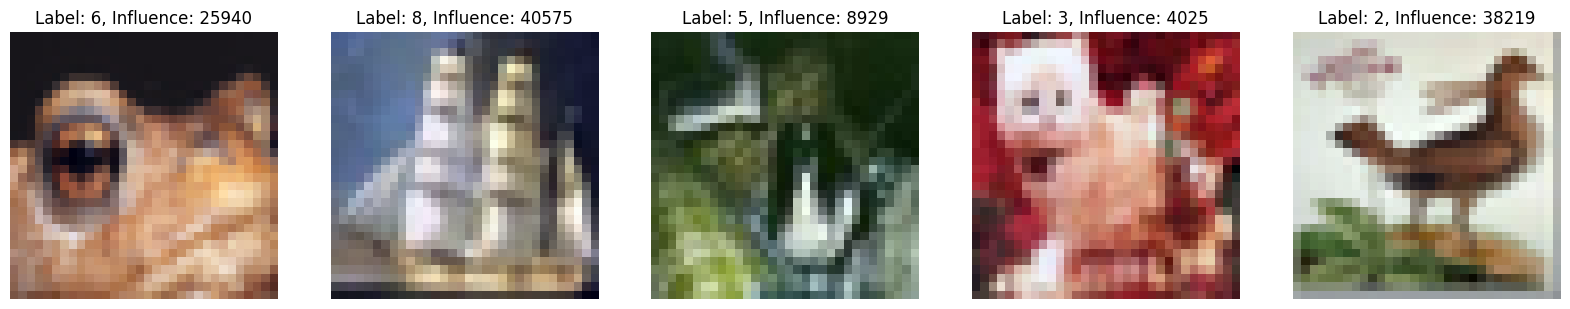

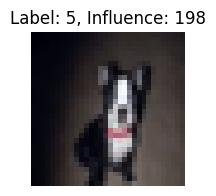

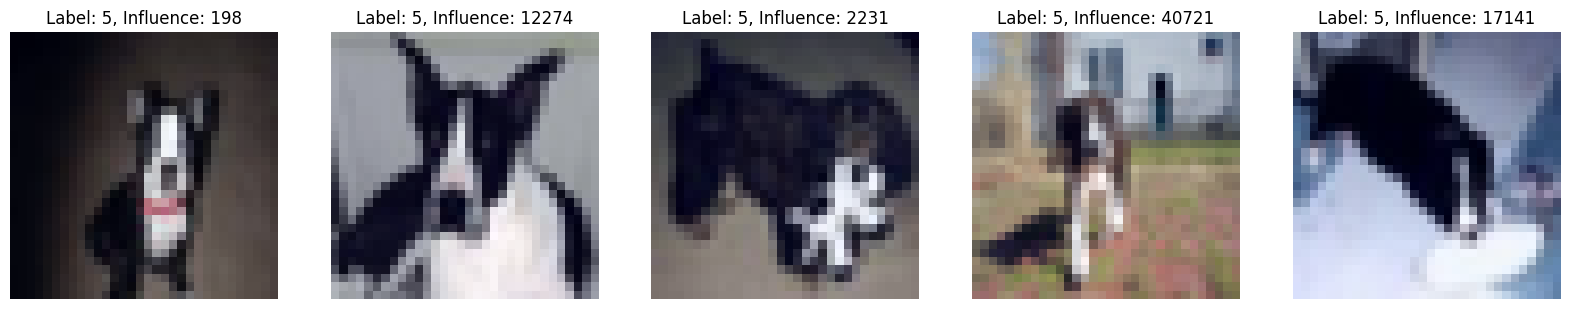

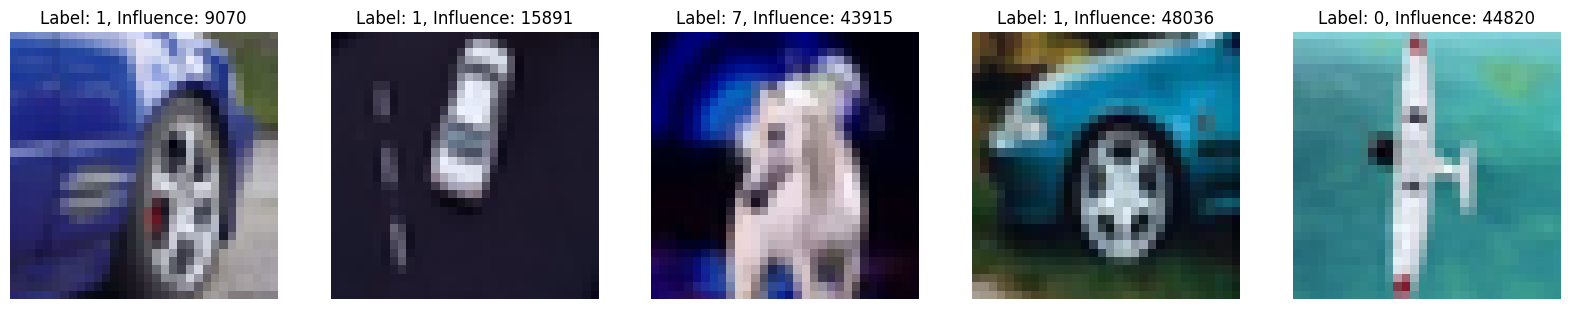

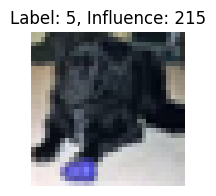

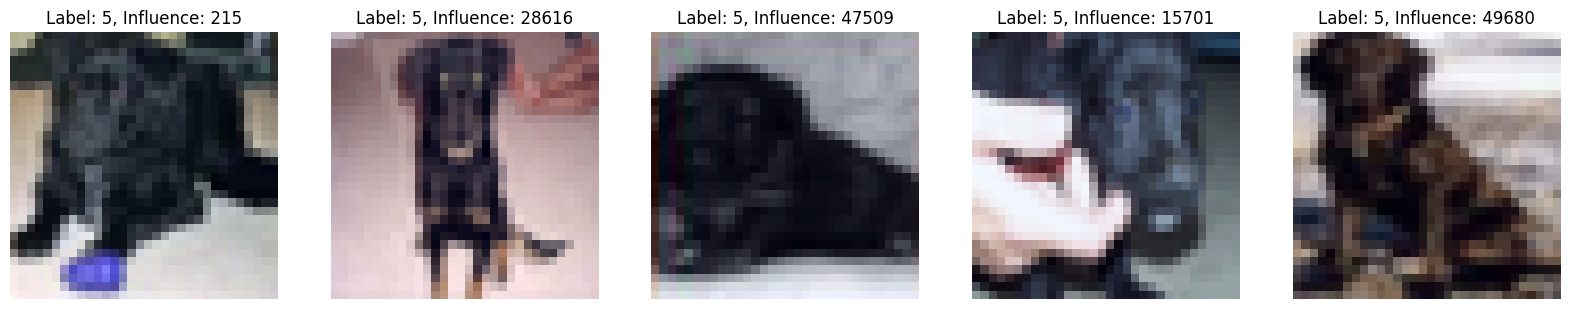

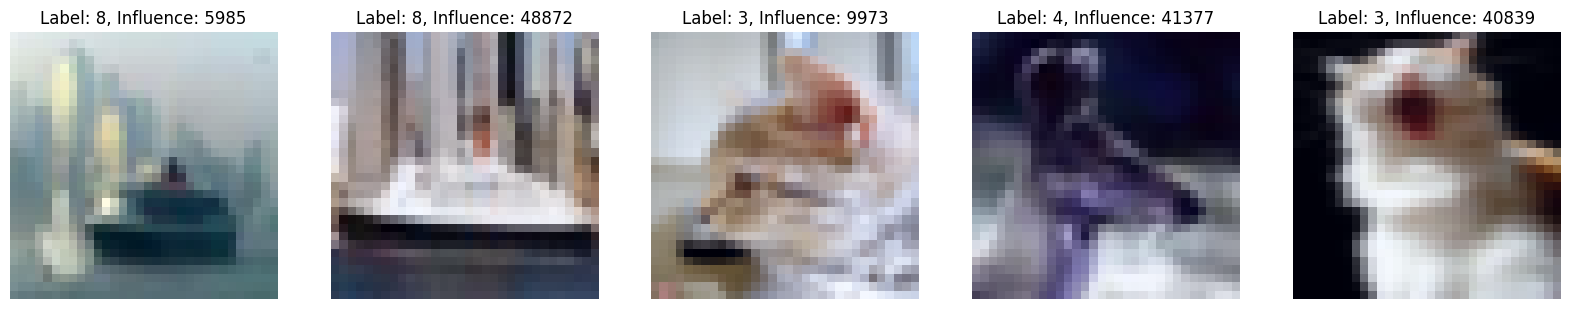

In [ ]:
for idx in np.arange(50_000)[np.array(train_labels) == 5][10:20]:
    # top_infls = scores_logit_5[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
    # bottom_infls = scores_logit_5[:, idx].argsort()[:5].cpu().numpy().tolist()
    top_infls = S[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
    bottom_infls = S[:, idx].argsort()[:5].cpu().numpy().tolist()
    plt.figure(figsize=(2, 2))
    plt.imshow(get_img(train_ds[idx][0]))
    plt.title(f"Label: {train_ds[idx][1]}, Influence: {idx}")
    plt.axis('off')
    plt.show()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, infl in enumerate(top_infls):
        axs[i].imshow(get_img(train_ds[infl][0]))
        axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        axs[i].axis('off')
    plt.show()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, infl in enumerate(bottom_infls):
        axs[i].imshow(get_img(train_ds[infl][0]))
        axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        axs[i].axis('off')
    plt.show()

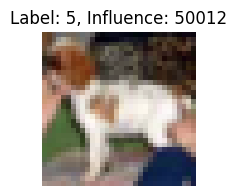

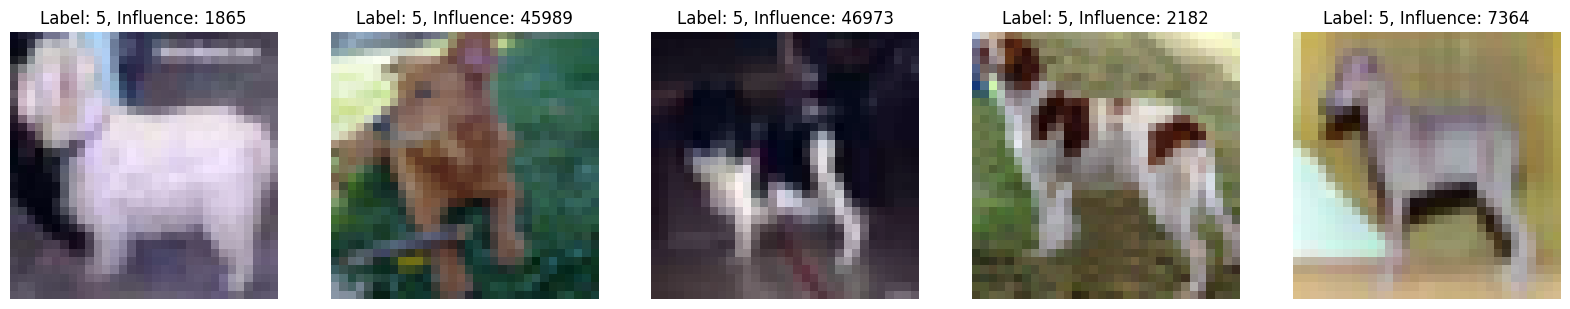

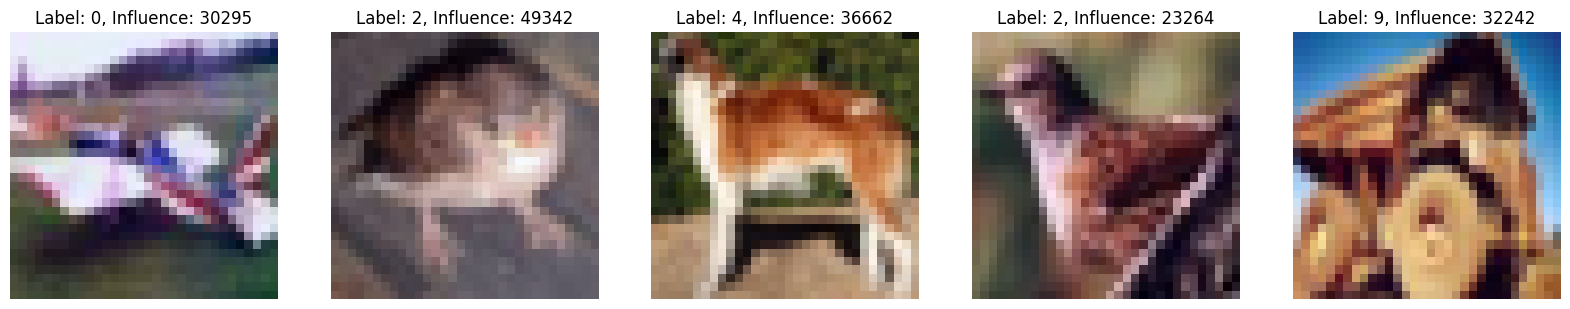

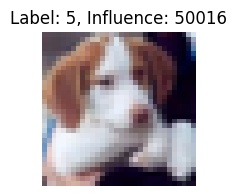

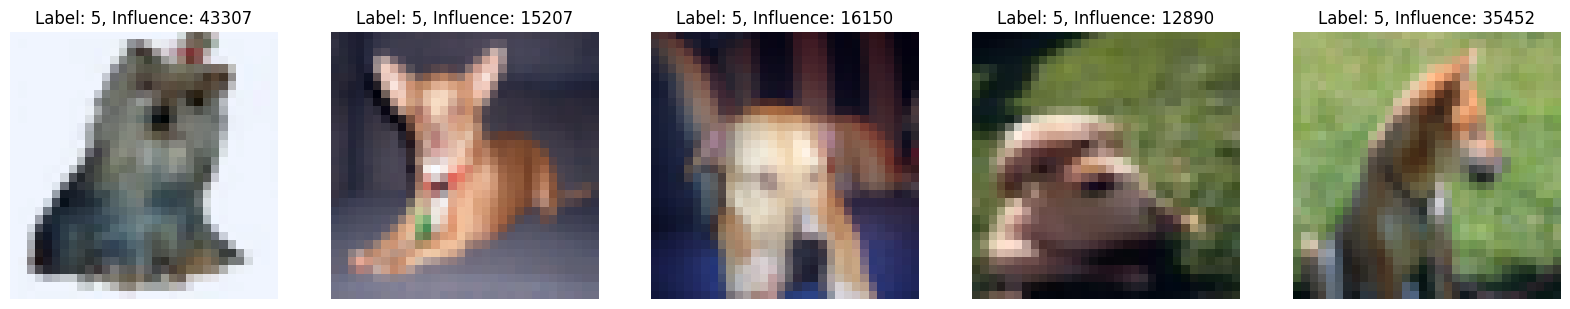

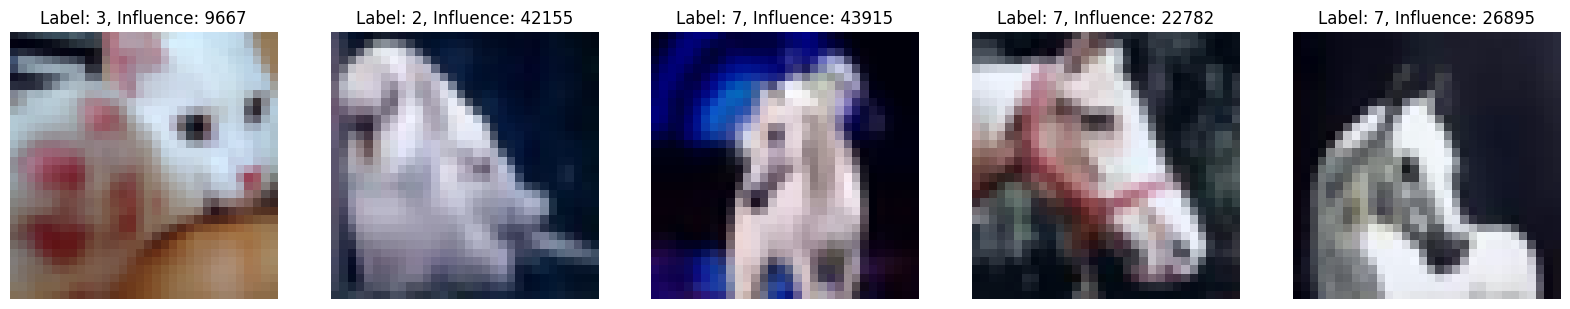

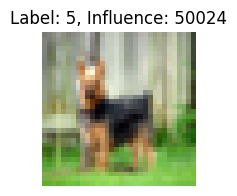

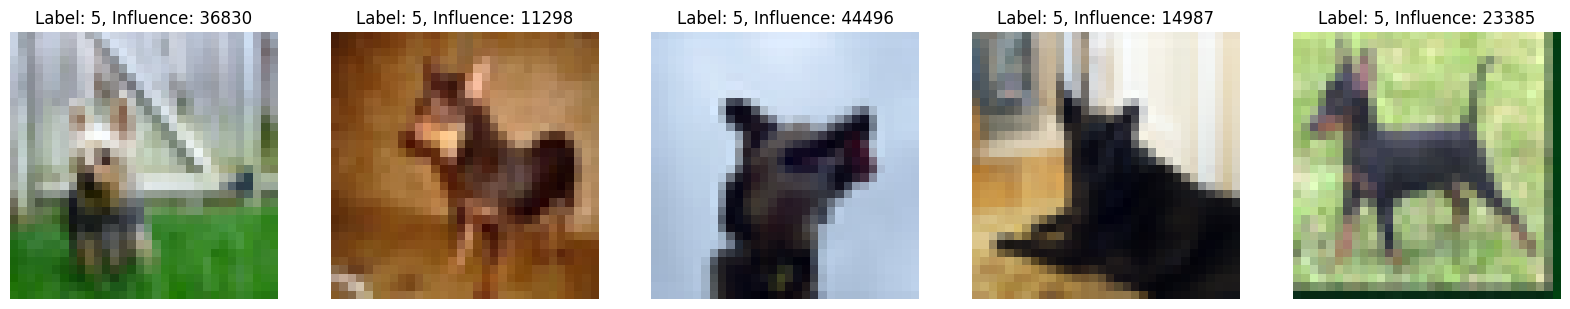

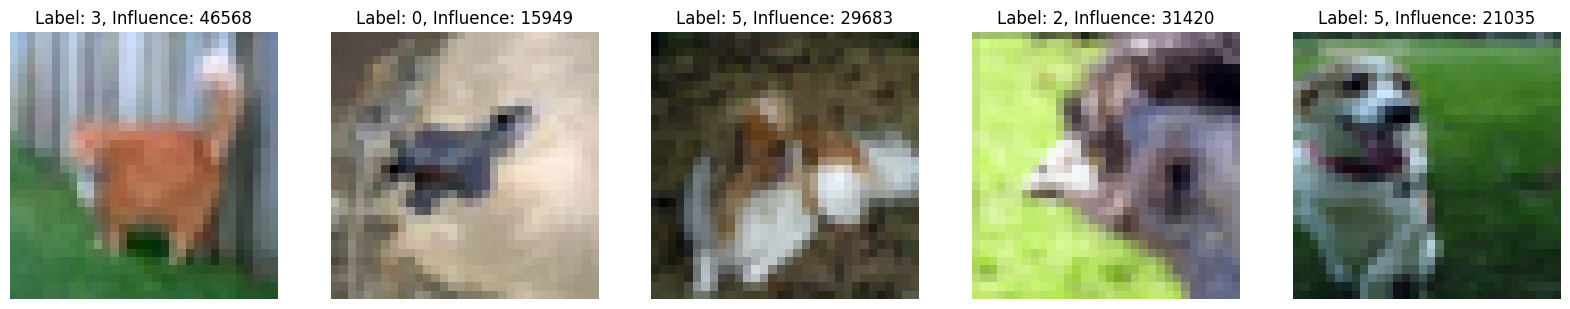

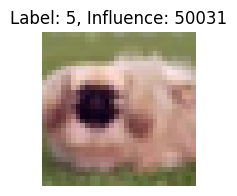

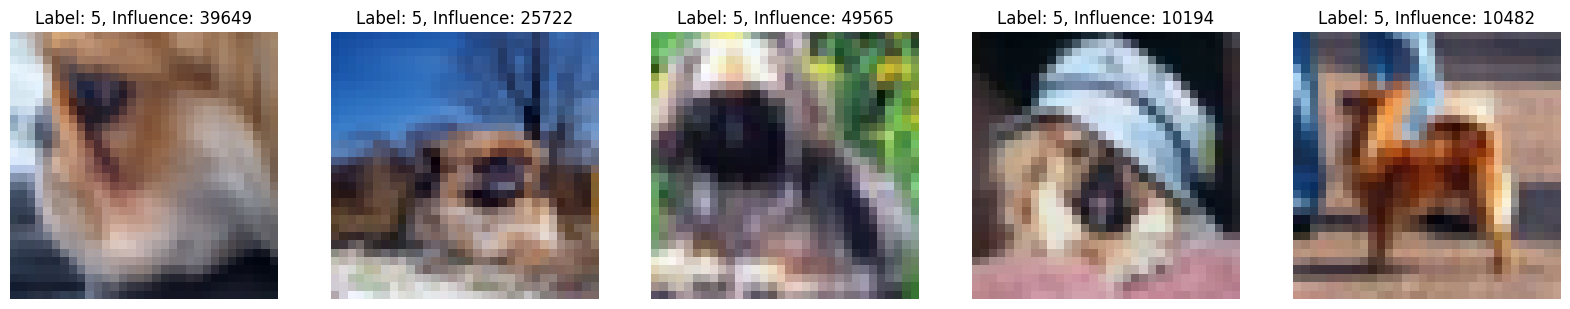

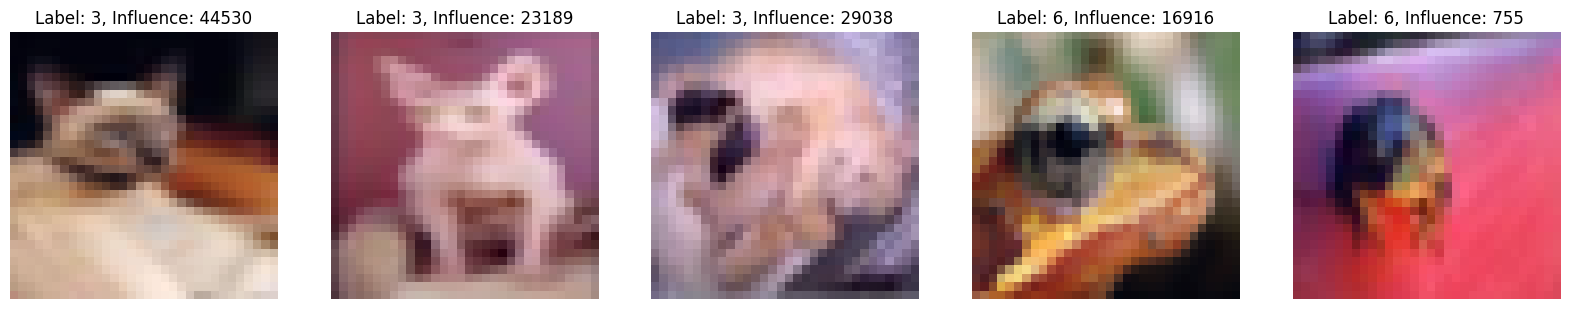

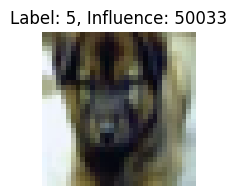

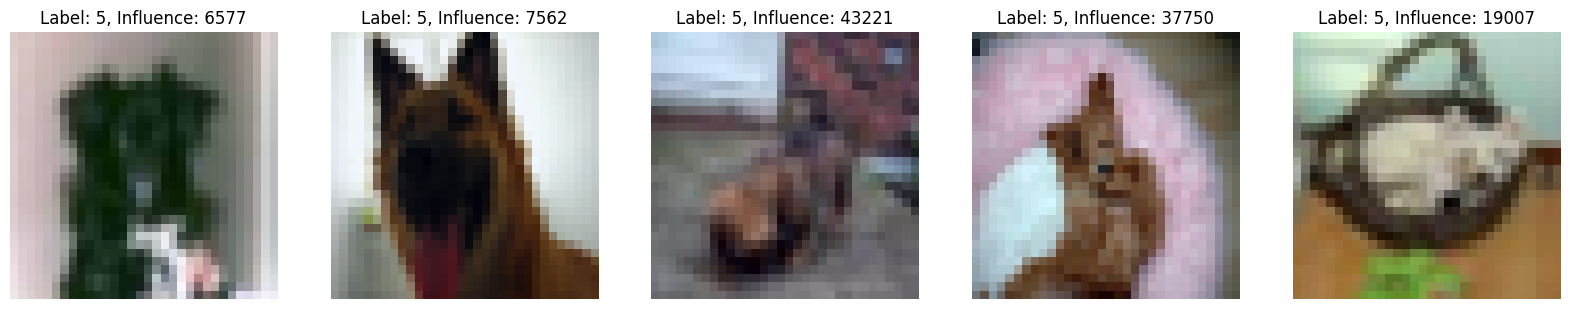

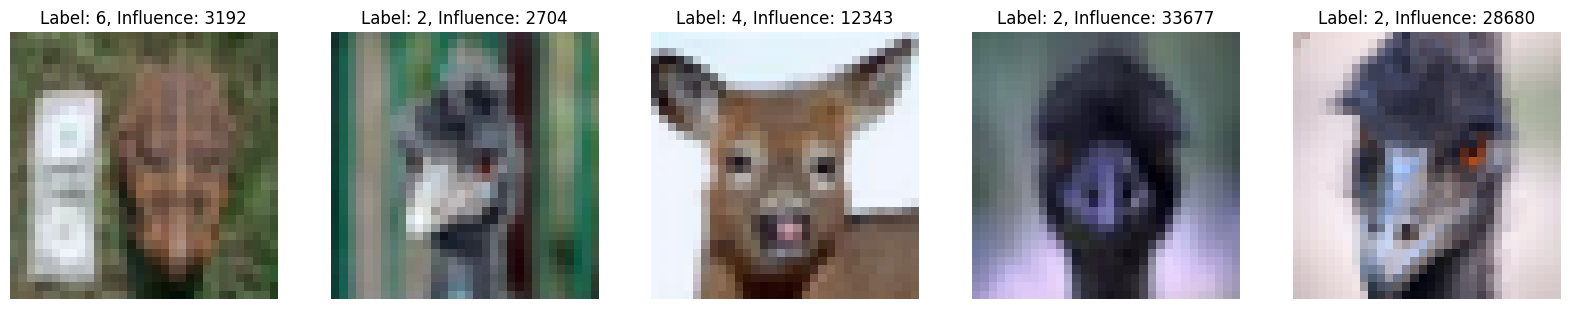

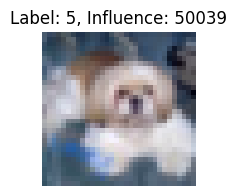

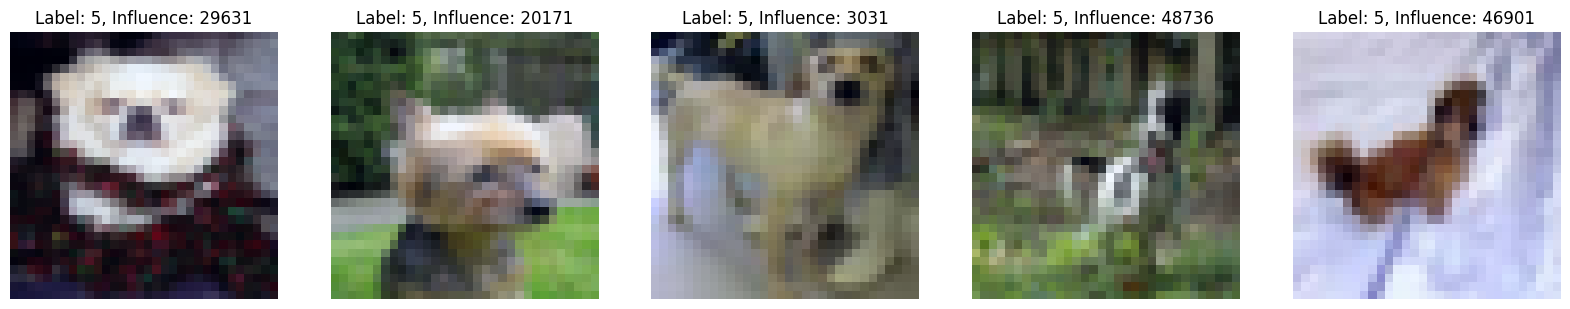

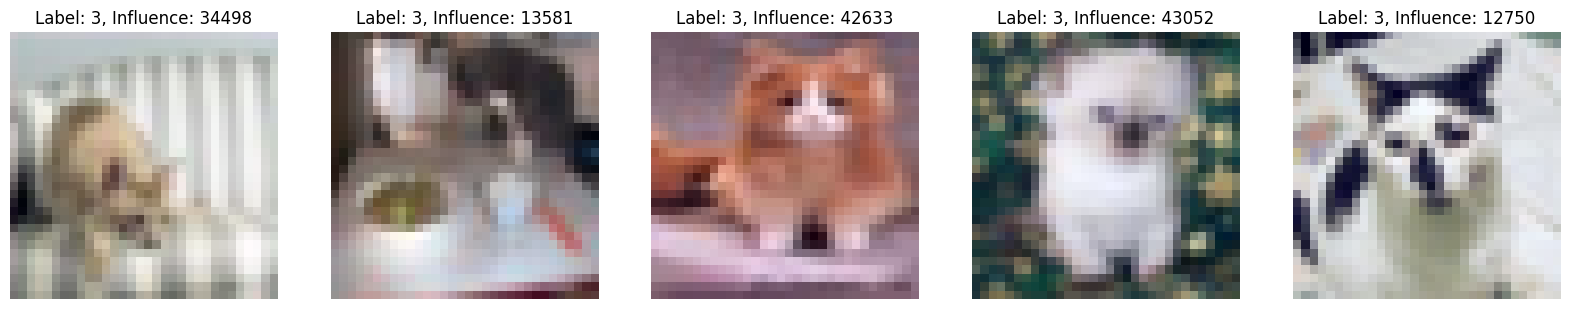

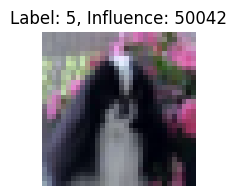

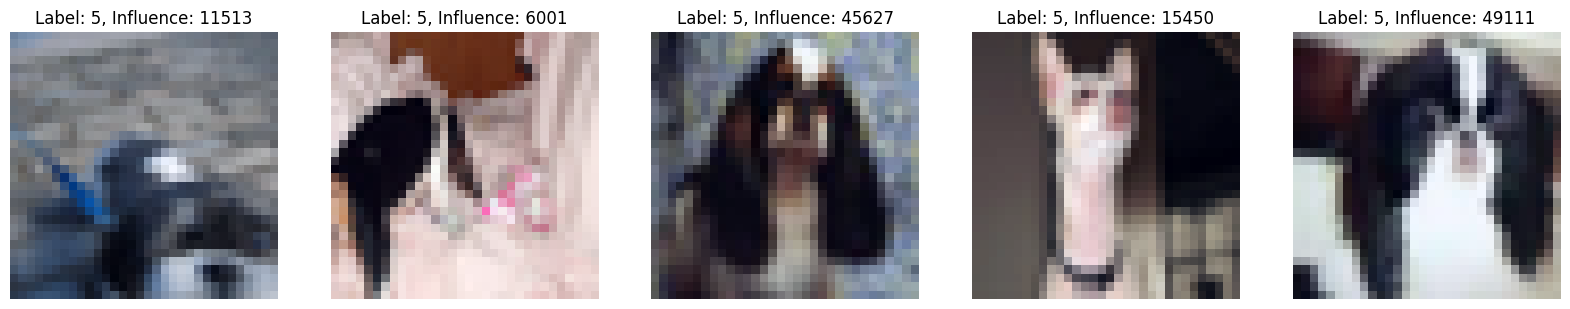

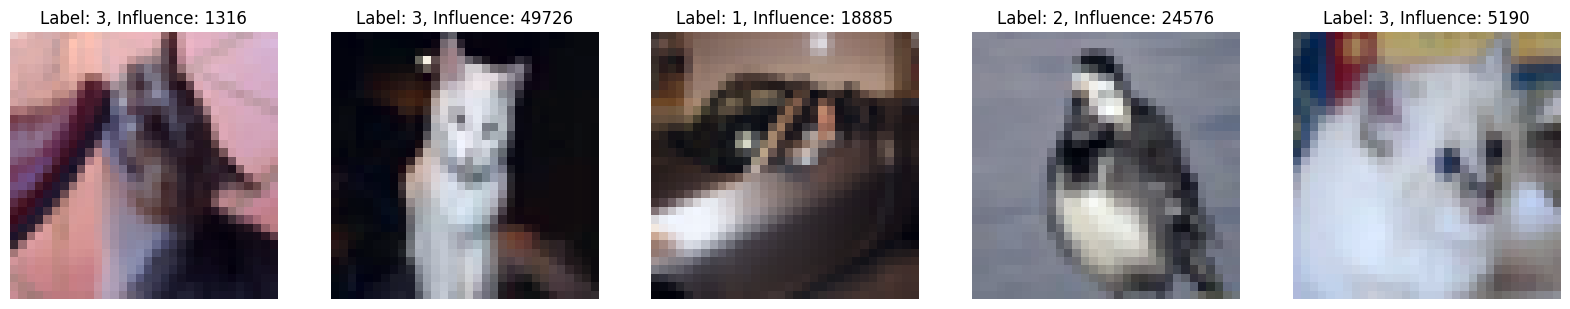

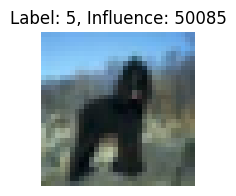

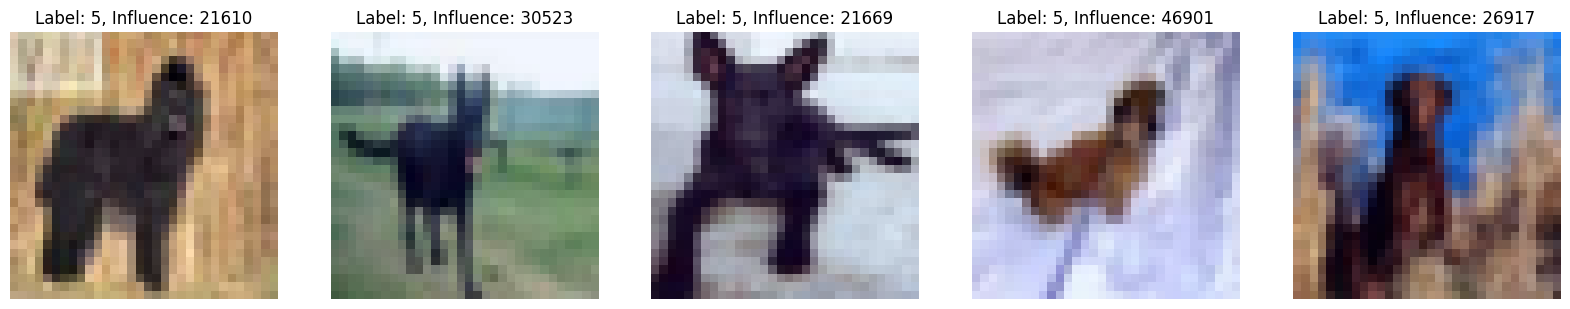

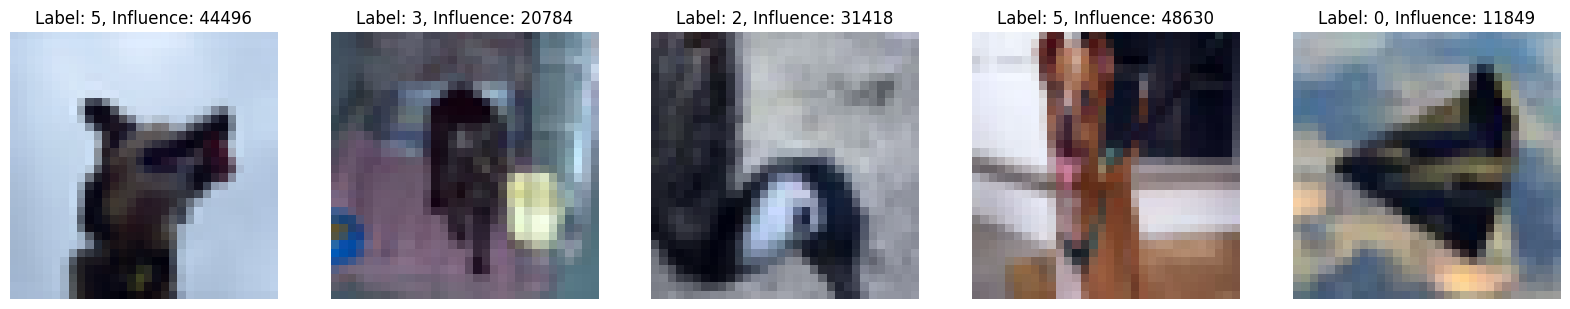

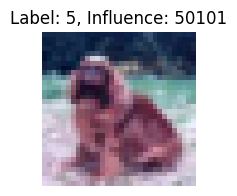

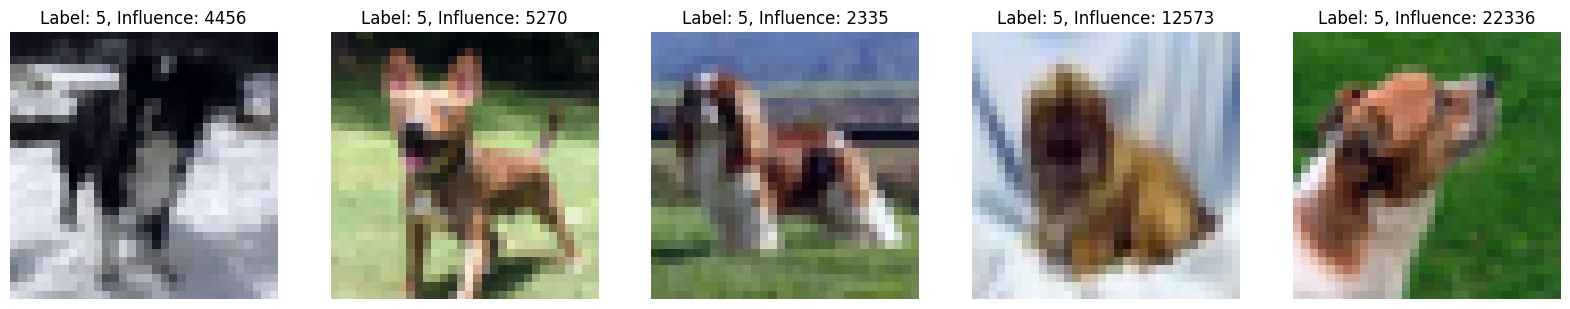

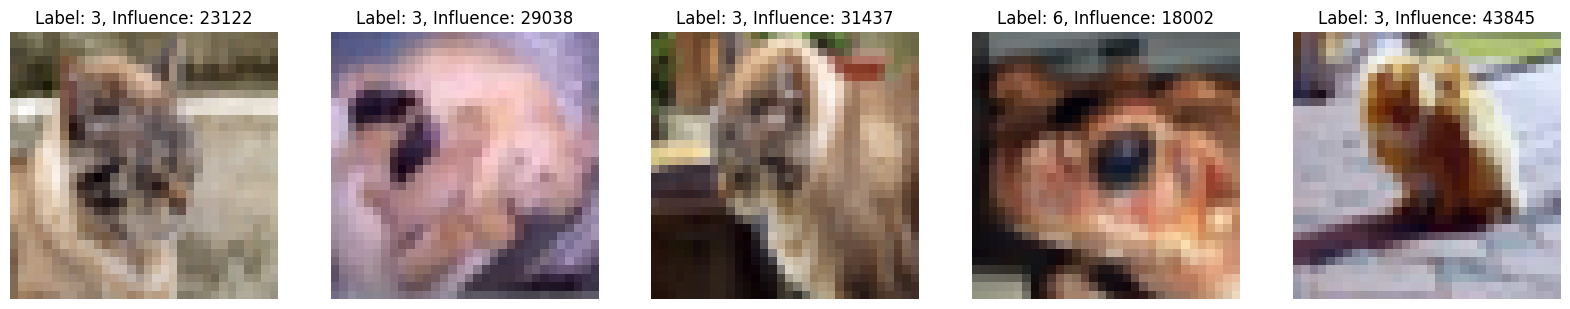

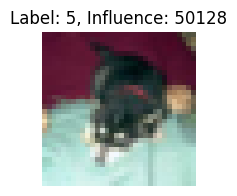

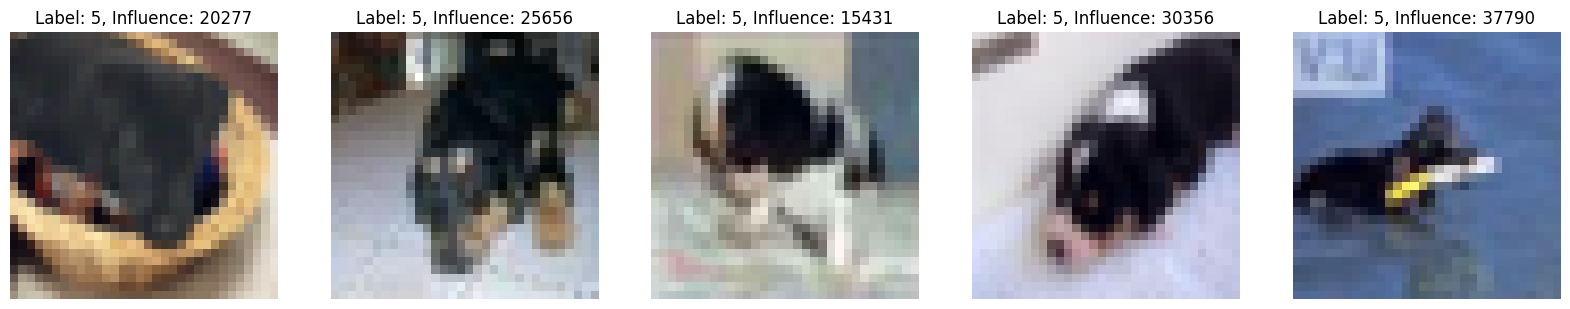

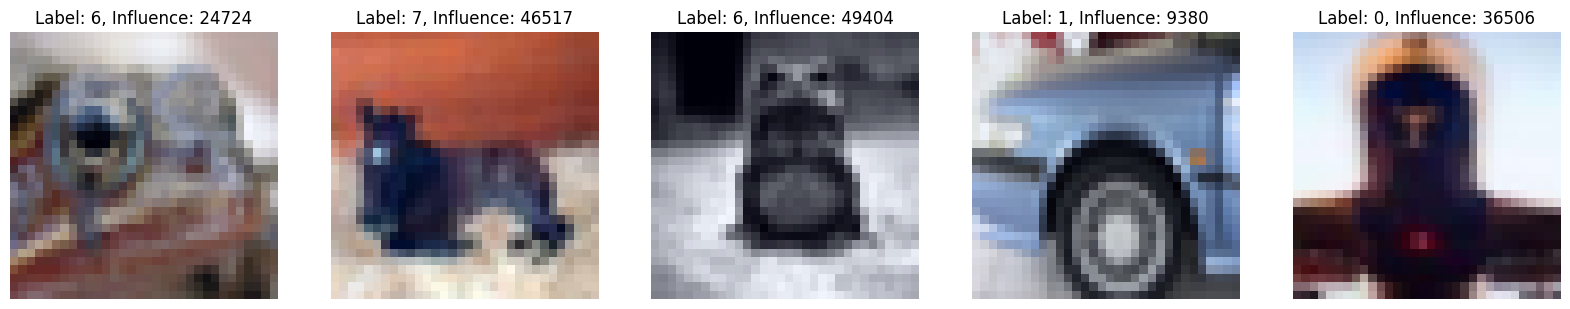

In [ ]:
# idx = 27
# idx = 40
for ii in np.arange(10_000)[np.array(val_labels) == 5][:10]:
    idx = ii + 50_000
    top_infls = scores_logit_5[:, idx].argsort()[-5:].cpu().numpy().tolist()[::-1]
    bottom_infls = scores_logit_5[:, idx].argsort()[:5].cpu().numpy().tolist()
    plt.figure(figsize=(2, 2))
    # plt.imshow(get_img(train_ds[idx][0]))
    # plt.title(f"Label: {train_ds[idx][1]}, Influence: {idx}")
    plt.imshow(get_img(val_ds[ii][0]))
    plt.title(f"Label: {val_ds[ii][1]}, Influence: {idx}")
    plt.axis('off')
    plt.show()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, infl in enumerate(top_infls):
        axs[i].imshow(get_img(train_ds[infl][0]))
        axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        axs[i].axis('off')
    plt.show()
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, infl in enumerate(bottom_infls):
        axs[i].imshow(get_img(train_ds[infl][0]))
        axs[i].set_title(f"Label: {train_ds[infl][1]}, Influence: {infl}")
        axs[i].axis('off')
    plt.show()